<a href="https://colab.research.google.com/github/aline-lessa/TrabalhoModMatIA/blob/main/PrevisaoDensidadeEmPocos_Luiza_Aline_MFernanda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição de Densidade Litológica em Poços de Petróleo

Este notebook aplica técnicas de aprendizado de máquina para prever a densidade litológica em poços, comparando os resultados com a equação de Gardner.

## Dados
- 10 poços
- 6 variáveis petrofísicas
- Rochas evaporíticas removidas

## Análises
- Correlação de Spearman
- PCA
- Lasso

## Modelos
- `SVR`
- `Decision Tree`
- `Artificial Neural Network`



# **Conectando ao Google Drive e importando dados**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
dataset_original = pd.read_excel('/content/drive/My Drive/IA/Trabalho Final/dataset/DadosDensDTCLitologia.xlsx')
dataset_original

Poço Prof. Medida DENSIDADE DT COMPRESSIONAL      Cota      TVD  \
0       POÇO09      2856,00      2,64           117,43  -2828,81  2854,81   
1       POÇO09      2856,15      2,35           115,93  -2828,96  2854,96   
2       POÇO09      2856,30      1,84           115,66  -2829,11  2855,11   
3       POÇO09      2856,46      1,78           116,73  -2829,27  2855,27   
4       POÇO09      2856,61      1,84           118,79  -2829,42  2855,42   
...        ...          ...       ...              ...       ...      ...   
152226  POÇO03      6025,13      2,60              NaN  -5953,53  5985,53   
152227  POÇO03      6025,29      2,59              NaN  -5953,69  5985,69   
152228  POÇO03      6025,44      2,56              NaN  -5953,84  5985,84   
152229  POÇO03      6025,59      2,54              NaN  -5953,99  5985,99   
152230  POÇO03      6025,74      2,54              NaN  -5954,14  5986,14   

       Litologia Interpretada (sistema)  
0                              FOLHELHO  
1                              FOLHELHO  
2                              FOLHELHO  
3                              FOLHELHO  
4                              FOLHELHO  
...                                 ...  
152226                          COQUINA  
152227                          COQUINA  
152228                          COQUINA  
152229                          COQUINA  
152230                          COQUINA  

[152231 rows x 7 columns]

Importando dados de LDA

In [ ]:
lda_df = pd.read_excel('/content/drive/My Drive/IA/Trabalho Final/dataset/DadosLDA.xlsx') #carrega arquivo com informações de LDA
print(lda_df)

     Poço Lâmina d'água
0  POÇO09       1888,00
1  POÇO08       1690,00
2  POÇO07       2001,00
3  POÇO10       2049,00
4  POÇO06       1818,00
5  POÇO04       1751,00
6  POÇO05       2062,04
7  POÇO01       2020,00
8  POÇO02       1929,00
9  POÇO03       2136,00


In [ ]:
dicionario_lda = dict(zip(lda_df['Poço'], lda_df["Lâmina d'água"])) #cria dicionário para mapeamento de LDA
print(dicionario_lda)

{'POÇO09': '1888,00', 'POÇO08': '1690,00', 'POÇO07': '2001,00', 'POÇO10': '2049,00', 'POÇO06': '1818,00', 'POÇO04': '1751,00', 'POÇO05': '2062,04', 'POÇO01': '2020,00', 'POÇO02': '1929,00', 'POÇO03': '2136,00'}


In [ ]:
dataset_original.loc[:,"Lâmina d'água"] = dataset_original["Poço"].map(dicionario_lda)

Substituindo ',' por '.' e atribuindo tipo correto às colunas numéricas

In [ ]:
colunas_para_converter = ['Prof. Medida', 'DENSIDADE', 'DT COMPRESSIONAL', 'Cota', 'TVD', "Lâmina d'água"] #colunas para converter vírgula em ponto

for col in colunas_para_converter:
    dataset_original.loc[:, col] = (
        dataset_original[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

In [ ]:
dataset_original.loc[:,"Soterramento"] = - dataset_original["Lâmina d'água"] - dataset_original['Cota'] #cria coluna de soterramento

In [ ]:
dataset = dataset_original.copy()

# Removendo a coluna "TVD", que é redundante com a informação dada por cota
dataset = dataset.drop(columns=["TVD"])

In [ ]:
dataset.describe()

Poço  Prof. Medida  DENSIDADE  DT COMPRESSIONAL       Cota  \
count   152231     152231.00  119404.00          142021.0  152231.00   
unique      10      94173.00     214.00           12301.0  122690.00   
top     POÇO04       3083.97       2.05             124.0   -2976.82   
freq     23785          7.00    5089.00             496.0       4.00   

       Litologia Interpretada (sistema)  Lâmina d'água  Soterramento  
count                            152231       152231.0     152231.00  
unique                               32           10.0     130386.00  
top                              HALITA         1751.0        757.55  
freq                              47807        23785.0          5.00

In [ ]:
dataset.isnull().sum()

Poço                                    0
Prof. Medida                            0
DENSIDADE                           32827
DT COMPRESSIONAL                    10210
Cota                                    0
Litologia Interpretada (sistema)        0
Lâmina d'água                           0
Soterramento                            0
dtype: int64

## Excluindo linhas com dados em branco e evaporitos

In [ ]:
# Lista das litologias evaporíticas
evaporitos = ['ANIDRITA', 'HALITA', 'CARNALITA', 'TAQUIDRITA', 'SILVINITA']

# Total original
n_total = dataset.shape[0]

# Remove linhas com NaN
dataset = dataset.dropna()
n_sem_nan = dataset.shape[0]
perc_nan = (n_total - n_sem_nan) / n_total * 100

# Remove evaporitos
dataset = dataset[~dataset['Litologia Interpretada (sistema)'].isin(evaporitos)]
n_sem_evaporitos = dataset.shape[0]
perc_evaporitos = (n_sem_nan - n_sem_evaporitos) / n_total * 100

# Resultado final
print(f"Total de linhas originais: {n_total}")
print(f"Removidas por valores ausentes: {n_total - n_sem_nan} linhas ({perc_nan:.2f}%)")
print(f"Removidas por litologias evaporíticas: {n_sem_nan - n_sem_evaporitos} linhas ({perc_evaporitos:.2f}%)")
print(f"Total final de linhas: {n_sem_evaporitos} ({(n_sem_evaporitos / n_total) * 100:.2f}% do original)")


Total de linhas originais: 152231
Removidas por valores ausentes: 41790 linhas (27.45%)
Removidas por litologias evaporíticas: 29582 linhas (19.43%)
Total final de linhas: 80859 (53.12% do original)


In [ ]:
dataset.isnull().sum()

Poço                                0
Prof. Medida                        0
DENSIDADE                           0
DT COMPRESSIONAL                    0
Cota                                0
Litologia Interpretada (sistema)    0
Lâmina d'água                       0
Soterramento                        0
dtype: int64

In [ ]:
dataset.describe()

Poço  Prof. Medida  DENSIDADE  DT COMPRESSIONAL      Cota  \
count    80859      80859.00   80859.00           80859.0  80859.00   
unique      10      51071.00     207.00           12088.0  64134.00   
top     POÇO08       2853.69       2.12             124.0  -3028.79   
freq     16811          7.00    2222.00             466.0      4.00   

       Litologia Interpretada (sistema)  Lâmina d'água  Soterramento  
count                             80859        80859.0      80859.00  
unique                               27           10.0      71934.00  
top                            FOLHELHO         1690.0        758.16  
freq                              43249        16811.0          5.00

# **Análise de outliers**

In [ ]:
# Cria cópia da dataset somente com colunas numéricas
numeric_dataset = dataset.copy()
del numeric_dataset['Poço']
del numeric_dataset['Litologia Interpretada (sistema)']

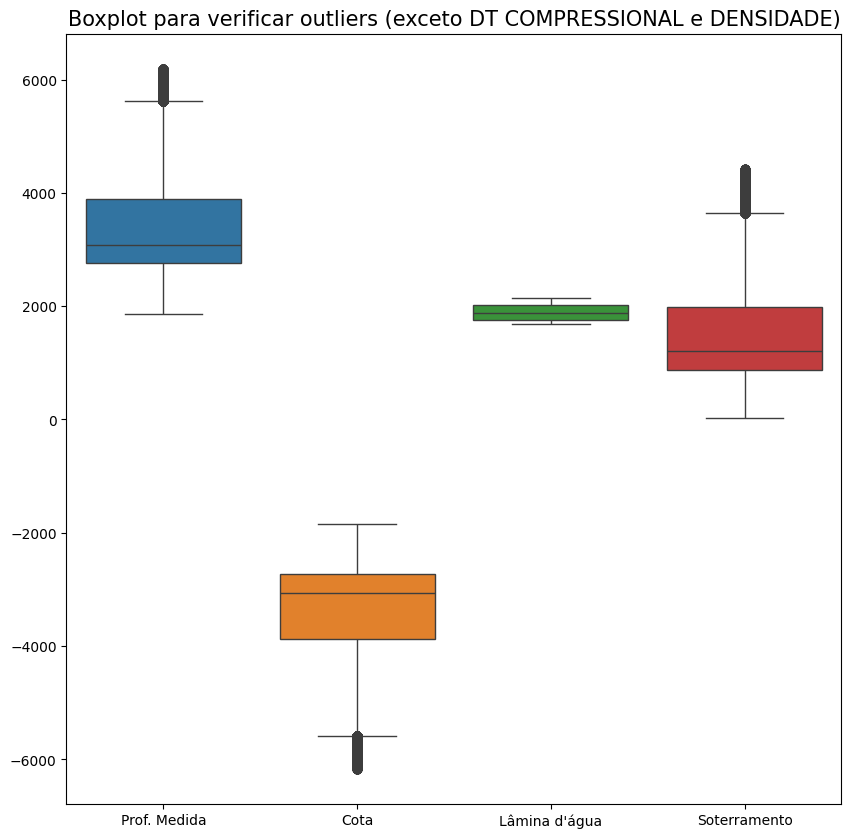

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Considera somente colunas de profundidade (Cota, TVD, Profundidade Medida, LDA, Soterramento)
dados_para_boxplot = numeric_dataset.drop(columns=["DT COMPRESSIONAL", "DENSIDADE"])

# Cria o boxplot
fig2 = plt.figure(figsize=(10, 10))
sns.boxplot(data=dados_para_boxplot)

# Adiciona título
plt.title('Boxplot para verificar outliers (exceto DT COMPRESSIONAL e DENSIDADE)', fontsize=15)

# Exibe o gráfico
plt.show()


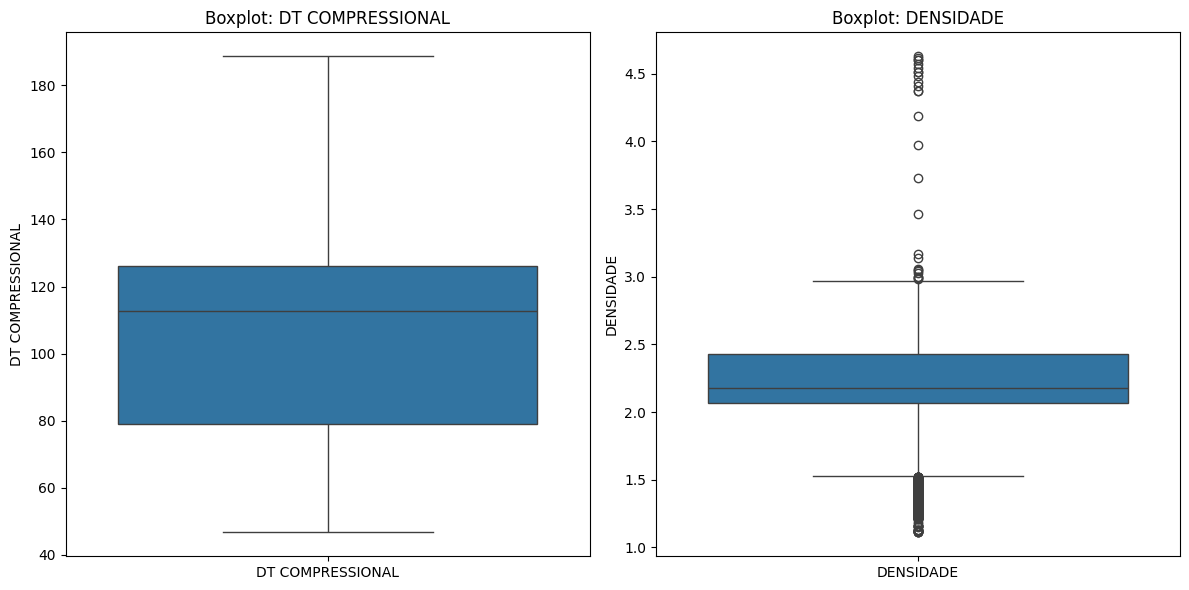

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleciona apenas as colunas desejadas
colunas = ["DT COMPRESSIONAL", "DENSIDADE"]

# Cria os subplots lado a lado
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Cria um boxplot para cada coluna
for i, col in enumerate(colunas):
    sns.boxplot(data=numeric_dataset[[col]], ax=axes[i], orient='v')
    axes[i].set_title(f'Boxplot: {col}')
    axes[i].set_ylabel(col)

# Ajusta layout e exibe
plt.tight_layout()
plt.show()

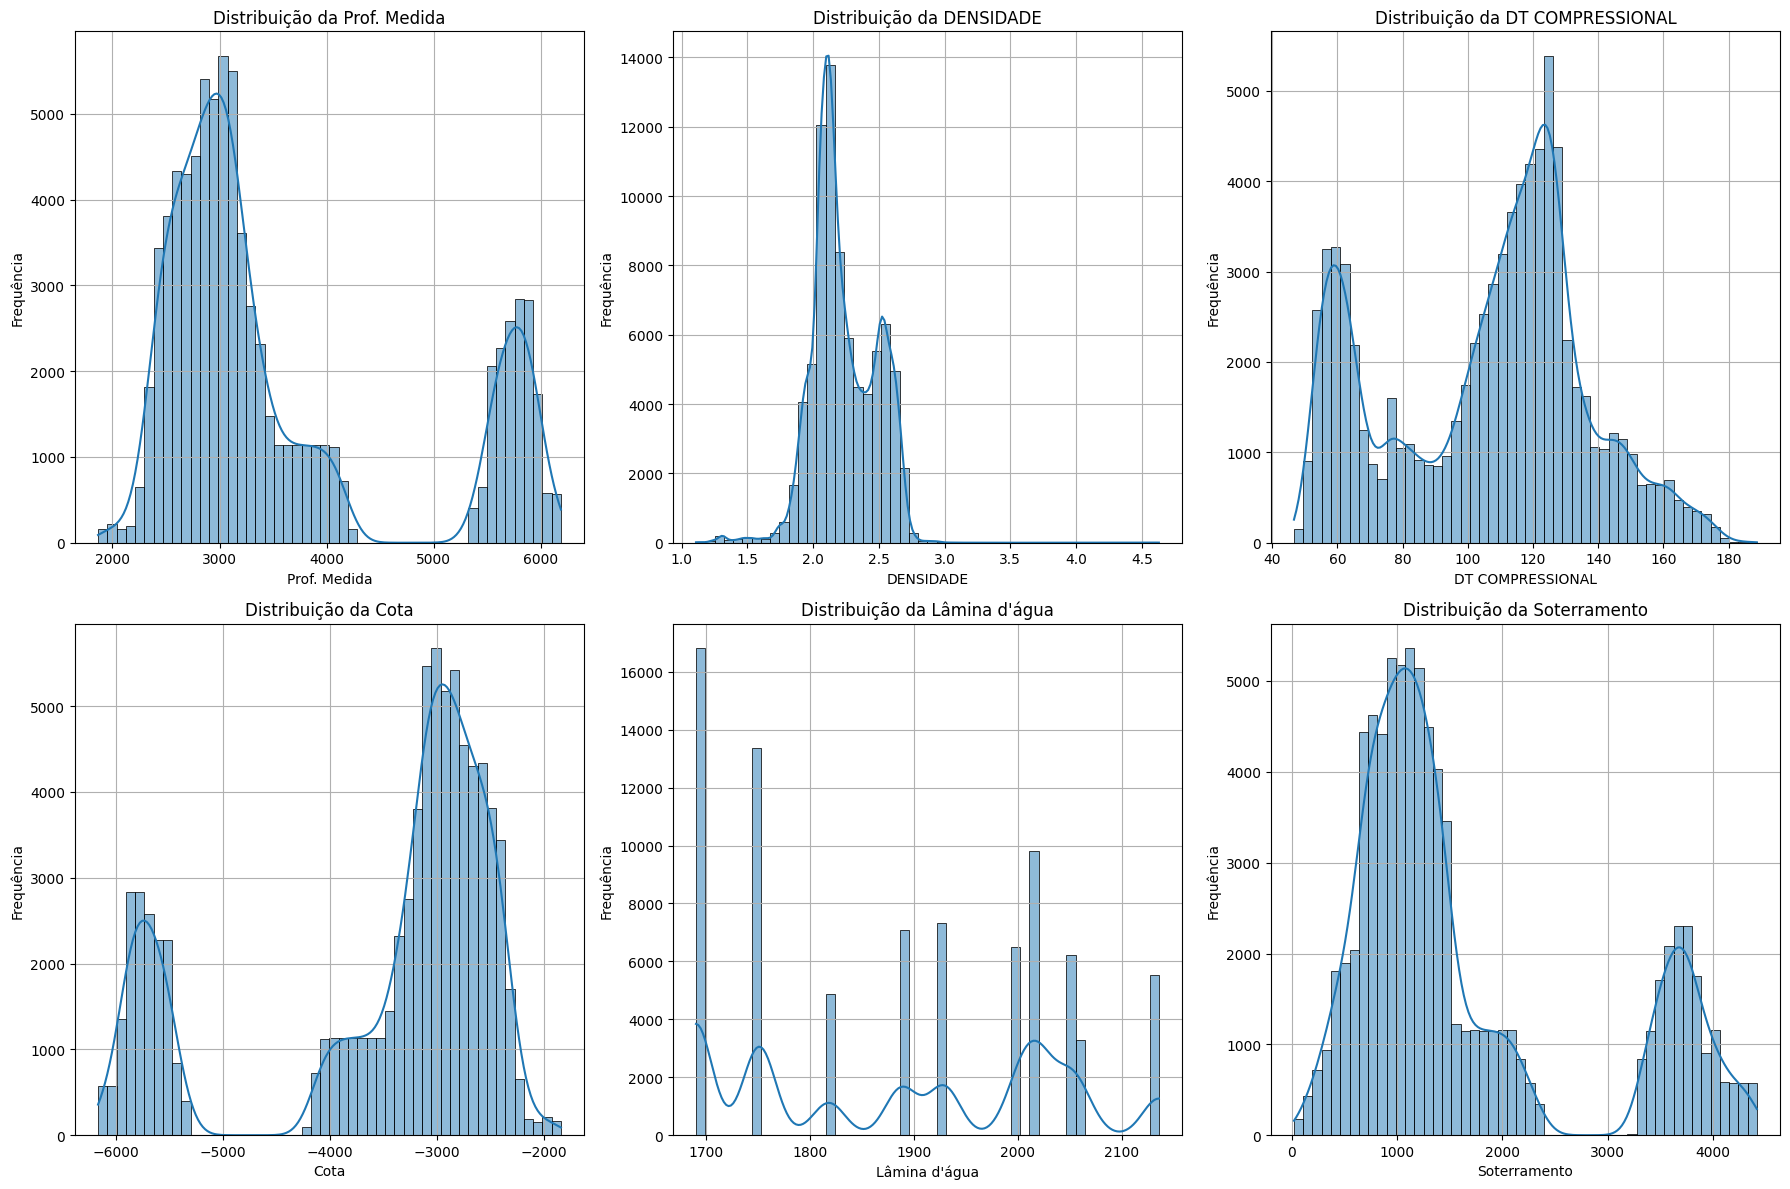

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleciona as colunas desejadas
colunas = ['Prof. Medida', 'DENSIDADE', 'DT COMPRESSIONAL', 'Cota', "Lâmina d'água", 'Soterramento']

# Cria subplots em grade 2x3 (6 espaços)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()  # Transforma 2D em 1D para iteração

# Gera um histograma com KDE para cada coluna
for i, col in enumerate(colunas):
    sns.histplot(numeric_dataset[col].dropna(), kde=True, bins=50, ax=axes[i])
    axes[i].set_title(f'Distribuição da {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')
    axes[i].grid(True)

# Ajusta layout
plt.tight_layout()
plt.show()




In [ ]:
densidade = numeric_dataset['DENSIDADE']
Q1 = densidade.quantile(0.25)
Q3 = densidade.quantile(0.75)
IQR = Q3 - Q1

# Limites superiores
limite_superior_comum = Q3 + 1.5 * IQR
limite_superior_extremo = Q3 + 3.0 * IQR

# Limites inferiores
limite_inferior_comum = Q1 - 1.5 * IQR
limite_inferior_extremo = Q1 - 3.0 * IQR

print(f"IQR: {IQR:.3f}")
print(f"Limite inferior para outliers comuns: {limite_inferior_comum:.3f}")
print(f"Limite inferior para outliers severos: {limite_inferior_extremo:.3f}")
print(f"Limite superior para outliers comuns: {limite_superior_comum:.3f}")
print(f"Limite superior para outliers severos: {limite_superior_extremo:.3f}")
print(f"Valores típicos para rochas sedimentares: entre 1.0 e 3.2 g/cm³")

outliers_comuns = densidade[densidade > limite_superior_comum]
outliers_severos = densidade[densidade > 3.51]
outliers_3_2 = densidade[densidade > 3.2]
outliers_inferiores_comuns = densidade[densidade < limite_inferior_comum]
outliers_inferiores_severos = densidade[densidade < limite_inferior_extremo]

print(f"Quantidade de outliers comuns acima do limite (>{limite_superior_comum:.3f} g/cm³): {len(outliers_comuns)}")
print(f"Quantidade de outliers severos acima do limite (>{limite_superior_extremo:.3f} g/cm³): {len(outliers_severos)}")
print(f"Quantidade de outliers acima de 3.2 g/cm³ (limite típico para rochas sedimentares): {len(outliers_3_2)}")
print(f"Quantidade de outliers comuns abaixo do limite (<{limite_inferior_comum:.3f} g/cm³): {len(outliers_inferiores_comuns)}")
print(f"Quantidade de outliers severos abaixo do limite: (<{limite_inferior_extremo:.3f} g/cm³): {len(outliers_inferiores_severos)}")
print(f"Quantidade de outliers abaixo de 1.0 g/cm³ (limite típico para rochas sedimentares): {len(densidade[densidade < 1])}")


IQR: 0.360
Limite inferior para outliers comuns: 1.530
Limite inferior para outliers severos: 0.990
Limite superior para outliers comuns: 2.970
Limite superior para outliers severos: 3.510
Valores típicos para rochas sedimentares: entre 1.0 e 3.2 g/cm³
Quantidade de outliers comuns acima do limite (>2.970 g/cm³): 27
Quantidade de outliers severos acima do limite (>3.510 g/cm³): 16
Quantidade de outliers acima de 3.2 g/cm³ (limite típico para rochas sedimentares): 17
Quantidade de outliers comuns abaixo do limite (<1.530 g/cm³): 545
Quantidade de outliers severos abaixo do limite: (<0.990 g/cm³): 0
Quantidade de outliers abaixo de 1.0 g/cm³ (limite típico para rochas sedimentares): 0


# **Remoção dos Outliers de DTC e DENSIDADE**

In [ ]:
# Remove valores fora da faixa de DT COMPRESSIONAL (40 a 240 µs/pé)
dataset = dataset[(dataset['DT COMPRESSIONAL'] >= 40) & (dataset['DT COMPRESSIONAL'] <= 240)]
n_sem_dt_outliers = dataset.shape[0]
perc_dt_outliers = (n_sem_evaporitos - n_sem_dt_outliers) / n_total * 100

# Remove valores fora da faixa de DENSIDADE (1 a 3.2 g/cm³)
dataset = dataset[(dataset['DENSIDADE'] >= 1.0) & (dataset['DENSIDADE'] <= 3.2)]
n_final = dataset.shape[0]
perc_densidade_outliers = (n_sem_dt_outliers - n_final) / n_total * 100

In [ ]:
# Resultado final
print(f"Total de linhas originais: {n_total}")
print(f"Removidas por valores ausentes: {n_total - n_sem_nan} linhas ({perc_nan:.2f}%)")
print(f"Removidas por litologias evaporíticas: {n_sem_nan - n_sem_evaporitos} linhas ({perc_evaporitos:.2f}%)")
print(f"Removidas por DT COMPRESSIONAL fora da faixa: {n_sem_evaporitos - n_sem_dt_outliers} linhas ({perc_dt_outliers:.2f}%)")
print(f"Removidas por DENSIDADE fora da faixa: {n_sem_dt_outliers - n_final} linhas ({perc_densidade_outliers:.2f}%)")
print(f"Total final de linhas: {n_final} ({(n_final / n_total) * 100:.2f}% do original)")

Total de linhas originais: 152231
Removidas por valores ausentes: 41790 linhas (27.45%)
Removidas por litologias evaporíticas: 29582 linhas (19.43%)
Removidas por DT COMPRESSIONAL fora da faixa: 0 linhas (0.00%)
Removidas por DENSIDADE fora da faixa: 17 linhas (0.01%)
Total final de linhas: 80842 (53.10% do original)


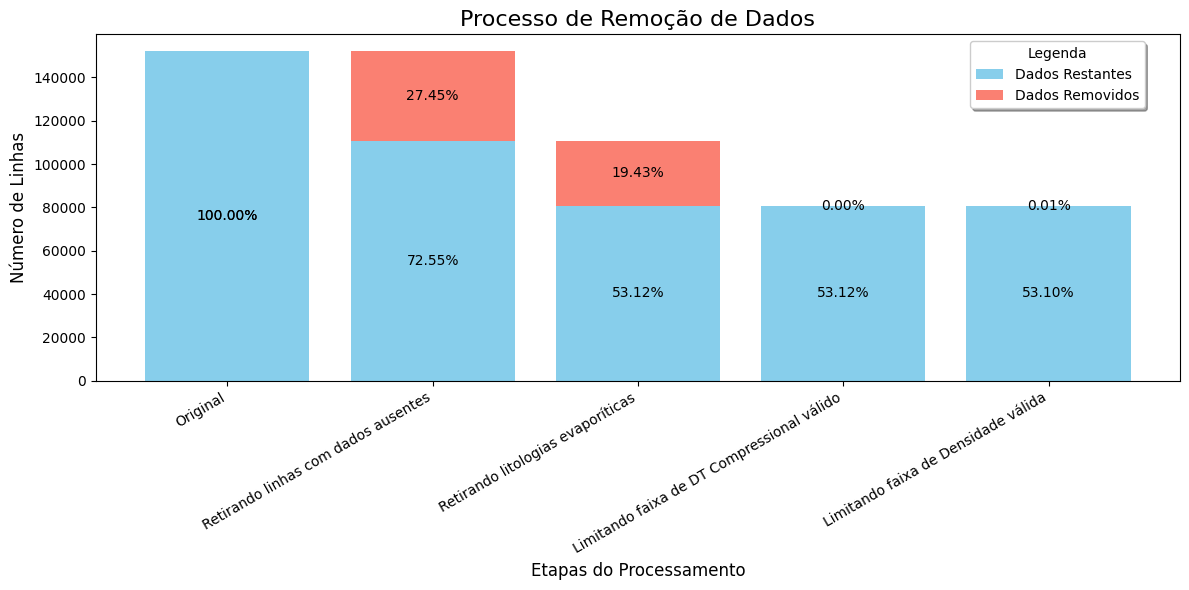

In [ ]:
# Dados para o gráfico
etapas = ['Original', 'Retirando linhas com dados ausentes', 'Retirando litologias evaporíticas',
          'Limitando faixa de DT Compressional válido', 'Limitando faixa de Densidade válida']

removidos = [
    0,  # Nenhuma linha removida no início
    n_total - n_sem_nan,  # Removidos por valores ausentes
    n_sem_nan - n_sem_evaporitos,  # Removidos por litologias evaporíticas
    n_sem_evaporitos - n_sem_dt_outliers,  # Removidos por DT COMPRESSIONAL fora da faixa
    n_sem_dt_outliers - n_final,  # Removidos por DENSIDADE fora da faixa
]

# Cálculo das linhas restantes por cada etapa
linhas_restantes = [n_total]  # A primeira etapa começa com todos os dados
for i in range(1, len(removidos)):
    linhas_restantes.append(linhas_restantes[-1] - removidos[i])  # Subtrai os dados removidos

# Visualização com gráfico de barras empilhadas
fig, ax = plt.subplots(figsize=(12, 6))  # Tamanho maior para evitar sobreposição

# Barras empilhadas para as linhas restantes (em azul)
ax.bar(etapas, linhas_restantes, label="Dados Restantes", color='skyblue')

# Barras para as linhas removidas (em vermelho)
# Corrigir para que as barras removidas empilhem corretamente
ax.bar(etapas[1:], removidos[1:], label="Dados Removidos", bottom=linhas_restantes[1:], color='salmon')

# Adicionando título e rótulos
ax.set_title('Processo de Remoção de Dados', fontsize=16)
ax.set_xlabel('Etapas do Processamento', fontsize=12)
ax.set_ylabel('Número de Linhas', fontsize=12)

# Adicionando percentuais nas barras
for i, (restante, removido) in enumerate(zip(linhas_restantes, removidos)):
    total = n_total

    # Para a primeira coluna (Original), não mostrar percentual de dados removidos
    if i == 0:
        ax.text(i, restante / 2, f'{(restante / total) * 100:.2f}%', ha='center', va='center', fontsize=10, color='black')
    else:
        ax.text(i, restante + removido / 2, f'{(removido / total) * 100:.2f}%', ha='center', va='center', fontsize=10, color='black')

    # Adicionando o percentual restante para todas as etapas
    ax.text(i, restante / 2, f'{(restante / total) * 100:.2f}%', ha='center', va='center', fontsize=10, color='black')

# Ajustando a legenda para o lado direito do gráfico
ax.legend(title="Legenda", loc="upper left", bbox_to_anchor=(0.8, 1), shadow=True)

# Melhorando a posição dos rótulos do eixo X
ax.set_xticks(range(len(etapas)))  # Coloca as posições dos rótulos
ax.set_xticklabels(etapas, rotation=30, ha="right")  # Aplica rotação e ajuste de alinhamento

# Exibindo o gráfico
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()




# Gráfico com Distribuição de litologia


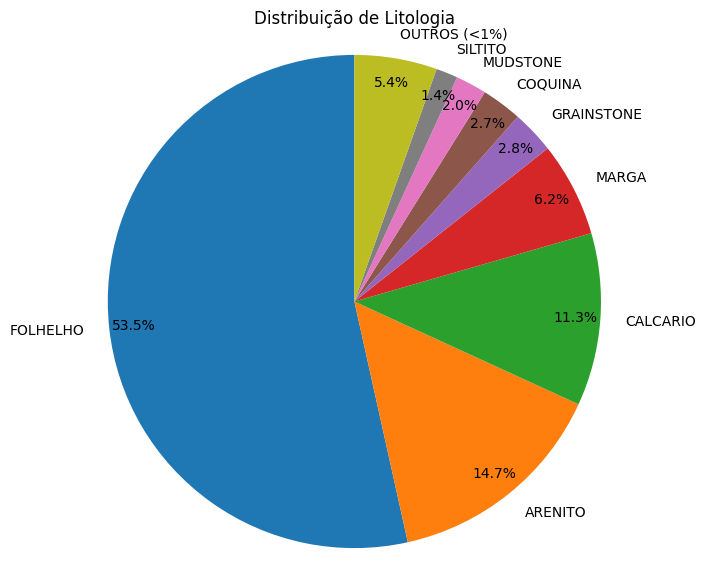

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Conta os valores absolutos
valores_abs = dataset['Litologia Interpretada (sistema)'].value_counts()
total = valores_abs.sum()

# Calcula porcentagem
valores_pct = valores_abs / total * 100

# Separa os dados
principais = valores_abs[valores_pct >= 1]
outros = valores_abs[valores_pct < 1].sum()

# Cria novo DataFrame com "Outros"
valores_com_outros = principais.copy()
if outros > 0:
    valores_com_outros['OUTROS (<1%)'] = outros

# Gera novo vetor de porcentagens
porcentagens = valores_com_outros / valores_com_outros.sum() * 100

# Função para mostrar apenas rótulos significativos
def mostrar_pct(pct):
    return f'{pct:.1f}%' if pct > 1 else ''

# Gráfico de pizza com "Outros"
plt.figure(figsize=(7, 7))
plt.pie(valores_com_outros, labels=valores_com_outros.index, autopct=mostrar_pct, startangle=90, pctdistance=0.9)
plt.title("Distribuição de Litologia")
plt.axis('equal')
plt.show()


In [ ]:
# Converte para DataFrame
tabela = valores_pct.reset_index()
tabela.columns = ['Classe', 'Porcentagem (%)']

# Exibe a tabela formatada
print(tabela)

                        Classe  Porcentagem (%)
0                     FOLHELHO        53.477153
1                      ARENITO        14.681725
2                     CALCARIO        11.309715
3                        MARGA         6.192326
4                   GRAINSTONE         2.817842
5                      COQUINA         2.652087
6                     MUDSTONE         2.032359
7                      SILTITO         1.427476
8                     ARGILITO         0.790431
9             FOLHELHO SILTICO         0.781772
10                   PACKSTONE         0.702605
11                    RUDSTONE         0.680339
12                ESFERULITITO         0.431706
13  VULCANICA NAO IDENTIFICADA         0.353777
14  ESTROMATOLITO ARBORESCENTE         0.270899
15                    DOLOMITO         0.241211
16  ESTROMATOLITO ARBUSTIFORME         0.225131
17               ESTROMATOLITO         0.186784
18                    LAMINITO         0.162044
19                  FLOATSTONE         0

# Gráfico com Distribuição de Dados por Poço

In [ ]:
# Conta os valores de poço
valores_poco_abs = dataset['Poço'].value_counts()
valores_poco_pct = valores_poco_abs / valores_poco_abs.sum() * 100

labels = valores_poco_pct.index

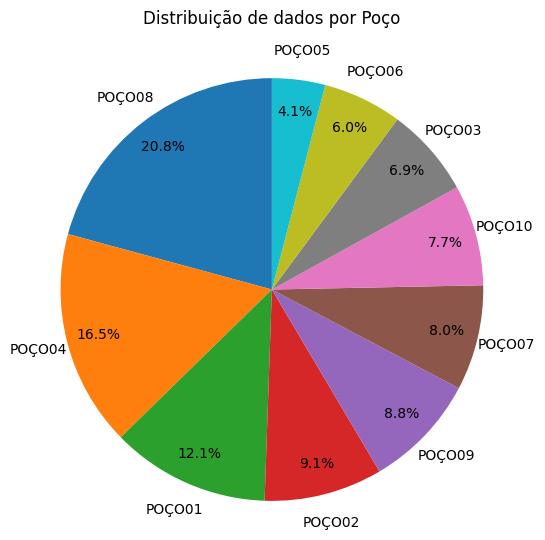

In [ ]:
# Cria o gráfico de pizza
plt.figure(figsize=(6, 6))
plt.pie(
    valores_poco_pct,
    labels=labels,
    autopct=mostrar_pct,
    startangle=90,
    pctdistance=0.85,
    labeldistance=1.14,
    textprops={'ha': 'center', 'fontsize': 10}  # Centraliza os labels horizontalmente
)
plt.title('Distribuição de dados por Poço', pad=25)
plt.axis('equal')  # Mantém formato circular
plt.show()

# Matrizes de correlação

## Montando Matriz de Correlação entre as variáveis para todo o DataSet

In [ ]:
# Calcula a correlação apenas nas colunas numéricas
corr_Pearson = numeric_dataset.corr() # correlação Pearson

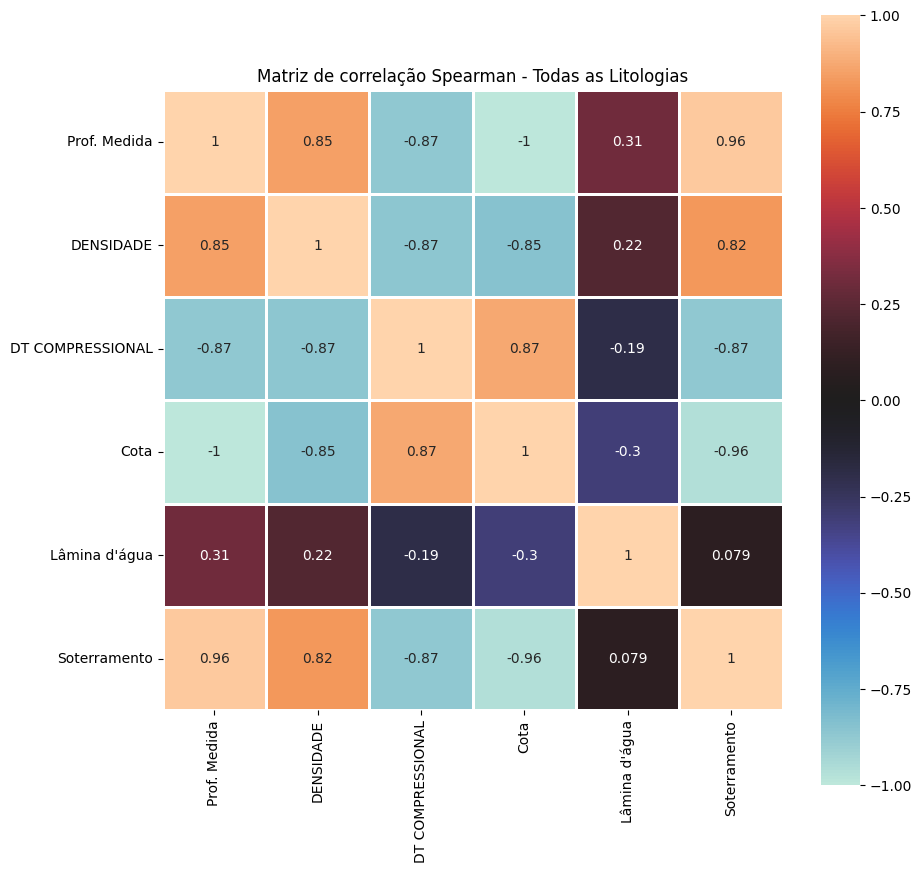

In [ ]:
import seaborn as sns

corr_Spearman = numeric_dataset.iloc[:,:].corr(method='spearman')

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(corr_Spearman,
                 vmin=-1,
                 vmax=1,
                 center=0,
                 square=True,
                 annot=True,
                 linewidths=0.8)
ax.set_ylim(len(corr_Spearman),0)
plt.title('Matriz de correlação Spearman - Todas as Litologias')
plt.show()

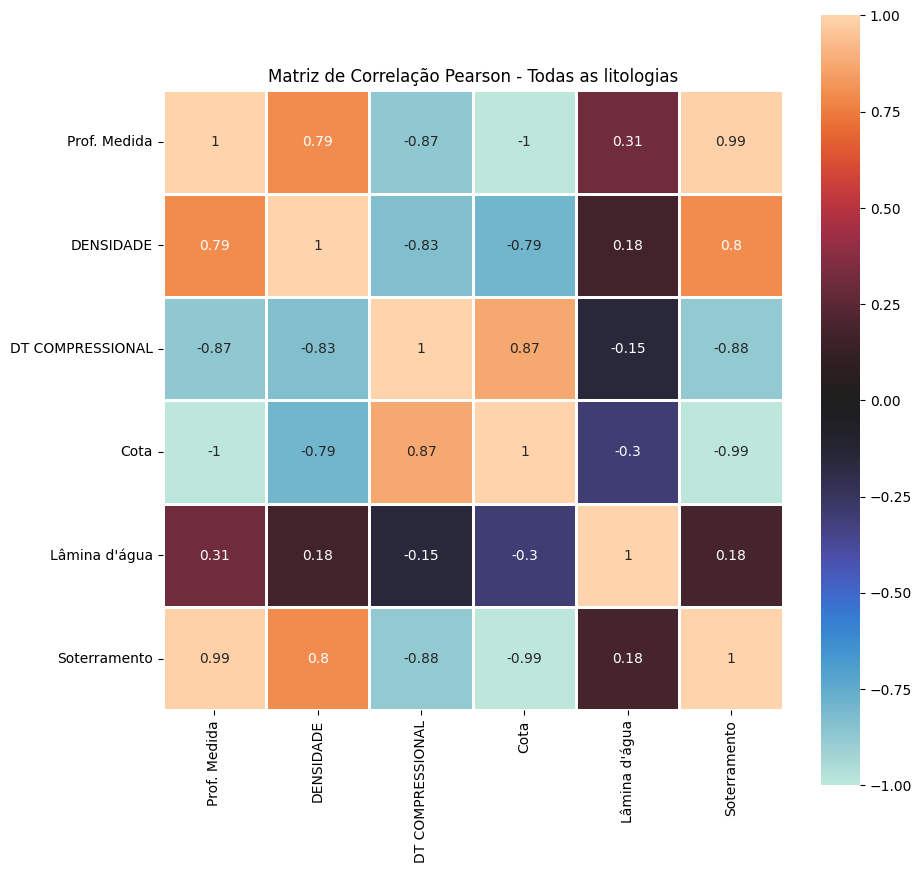

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

fig1 = plt.figure(figsize=(10,10))
ax = sns.heatmap(corr_Pearson,
                 vmin=-1,
                 vmax=1,
                 center=0,
                 square=True,
                 annot=True,
                 linewidths=0.8)
ax.set_ylim(len(corr_Pearson),0)
plt.title('Matriz de Correlação Pearson - Todas as litologias')
plt.show()

# Seleção de Variáveis

## PCA

In [ ]:
!pip install prince
import prince

# Configura PCA
pca = prince.PCA(
    n_components=7,
    n_iter=10,
    rescale_with_mean=True,
    rescale_with_std=True,
    engine='sklearn',
    random_state=200)

# Ajusta o modelo
pca = pca.fit(numeric_dataset)

# Mostra os autovalores
print(pca.eigenvalues_summary)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 5.5 MB/s eta 0:00:00
          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              4.611        76.84%                     76.84%
1              0.953        15.88%                     92.73%
2              0.302         5.04%                     97.76%
3              0.134         2.24%                    100.00%
4              0.000         0.00%                    100.00%
5              0.000         0.00%                    100.00%


O que isso mostra:

O componente 0 captura mais que 75% da variância total dos dados.

Os três primeiros componentes somam quase 98% da variância, o que significa que a maioria da informação dos dados pode ser representada em 2 ou 3 dimensões.

In [ ]:
pca.scree_plot()

alt.Chart(...)

In [ ]:
pca.column_contributions_.style.format('{:.0%}')

A componente 2 representa fortemente a DENSIDADE. Isso é essencial, porque mostra que a variabilidade da densidade está em uma direção separada das demais (componentes 0 e 1), sugerindo que ela tem comportamento próprio, e pode ser prevista por um subconjunto específico de variáveis.

In [ ]:
pca.column_correlations

component                0         1         2         3         4  \
variable                                                             
Prof. Medida      0.983655  0.028004 -0.169154  0.054842  0.004146   
DENSIDADE         0.876991 -0.111590  0.441524  0.153266  0.000004   
DT COMPRESSIONAL -0.929647  0.150548 -0.114191  0.316309  0.000004   
Cota             -0.983697 -0.023757  0.169368 -0.055548  0.002023   
Lâmina d'água     0.298512  0.952094  0.059890 -0.028658 -0.000286   
Soterramento      0.976212 -0.099678 -0.182596  0.061062 -0.002051   

component                    5  
variable                        
Prof. Medida      1.037450e-28  
DENSIDADE        -2.879697e-31  
DT COMPRESSIONAL  1.841268e-31  
Cota             -4.180153e-15  
Lâmina d'água    -5.283800e-16  
Soterramento     -4.050634e-15

In [ ]:
CP = pca.transform (numeric_dataset)
CP

component         0         1         2         3         4             5
0         -0.304922 -0.084514  1.852068  0.744887  0.003073 -5.464930e-15
1         -0.773072  0.044941  0.899427  0.201076  0.002047 -5.443428e-15
2         -1.630026  0.284549 -0.791899 -0.688470  0.000312 -5.366415e-15
3         -1.746274  0.318288 -0.998477 -0.761959  0.000139 -5.313075e-15
4         -1.673971  0.300319 -0.813409 -0.599974  0.000401 -5.291572e-15
...             ...       ...       ...       ...       ...           ...
152174     4.018384  1.211362 -0.634025 -0.127218  0.019320 -6.784859e-15
152175     4.033601  1.207286 -0.601833 -0.106193  0.019357 -6.772142e-15
152176     4.031370  1.208136 -0.603109 -0.101333  0.019362 -6.741854e-15
152177     4.047165  1.203858 -0.570653 -0.081435  0.019398 -6.577492e-15
152178     4.046492  1.204154 -0.571182 -0.079680  0.019400 -6.786820e-15

[80859 rows x 6 columns]

## PCA sem coluna Densidade

In [ ]:
# 1. Retira a variável alvo para PCA técnico
X = numeric_dataset.drop(columns=['DENSIDADE'])

# 2. Aplica PCA
pca = prince.PCA(
    n_components=6,
    n_iter=10,
    rescale_with_mean=True,
    rescale_with_std=True,
    engine='sklearn',
    random_state=200)
pca = pca.fit(X)

# Mostra os autovalores
print(pca.eigenvalues_summary)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              3.888        77.77%                     77.77%
1              0.942        18.84%                     96.60%
2              0.170         3.39%                    100.00%
3              0.000         0.00%                    100.00%
4              0.000         0.00%                    100.00%


In [ ]:
pca.scree_plot()

alt.Chart(...)

In [ ]:
pca.column_contributions_.style.format('{:.0%}')

In [ ]:
pca.column_correlations

component                0         1         2         3             4
variable                                                              
Prof. Medida      0.993702 -0.005875 -0.111825  0.004162 -5.736727e-29
DT COMPRESSIONAL -0.918318  0.170262 -0.357355  0.000002  3.777297e-32
Cota             -0.993609  0.010113  0.112401  0.002031  7.754672e-16
Lâmina d'água     0.321226  0.945924  0.045181 -0.000287  9.802065e-17
Soterramento      0.983478 -0.133826 -0.121889 -0.002058  7.514398e-16

In [ ]:
CP = pca.transform (numeric_dataset)
CP

component         0         1         2         3             4
0         -1.087086  0.179943  0.184866  0.001375  1.052220e-15
1         -1.064053  0.171318  0.227300  0.001356  1.143982e-15
2         -1.059748  0.169749  0.234850  0.001353  1.124721e-15
3         -1.075835  0.175865  0.204389  0.001366  1.073771e-15
4         -1.107010  0.187662  0.145857  0.001391  1.054510e-15
...             ...       ...       ...       ...           ...
152174     3.995793  1.075159 -0.162724  0.019760 -2.927186e-16
152175     3.994007  1.075885 -0.166519  0.019761 -3.031943e-16
152176     3.991611  1.076840 -0.171448  0.019763 -3.312409e-16
152177     3.990447  1.077335 -0.174115  0.019764 -4.932126e-16
152178     3.989726  1.077659 -0.175925  0.019764 -2.816436e-16

[80859 rows x 5 columns]

## LASSO considerando coluna litologia

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

df_lasso = dataset.copy()

df_lasso = df_lasso.drop(columns=['Poço']) #Removendo coluna não útil

# Converter categorias em variáveis dummies
df_lasso = pd.get_dummies(df_lasso, columns=['Litologia Interpretada (sistema)'], drop_first=True)

# Seleciona X (variáveis) e y (alvo)
X = df_lasso.drop(columns=['DENSIDADE'])
y = df_lasso['DENSIDADE']

# Criar pipeline com normalização + Lasso com validação cruzada
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42))

# Treinar o modelo
lasso.fit(X, y)

# Acessar o modelo treinado
modelo_lasso = lasso.named_steps['lassocv']

# Coeficientes das variáveis
coef = pd.Series(modelo_lasso.coef_, index=X.columns)
print("Coeficientes Lasso:")
print(coef)



Coeficientes Lasso:
Prof. Medida                                                   0.076235
DT COMPRESSIONAL                                              -0.121413
Cota                                                          -0.022300
Lâmina d'água                                                 -0.001807
Soterramento                                                   0.023810
Litologia Interpretada (sistema)_ARGILITO                     -0.025428
Litologia Interpretada (sistema)_BASALTO                       0.000656
Litologia Interpretada (sistema)_BRECHA CARBONATICA            0.000439
Litologia Interpretada (sistema)_CALCARIO                     -0.012936
Litologia Interpretada (sistema)_CALCARIO CRISTALINO           0.000064
Litologia Interpretada (sistema)_COQUINA                      -0.007361
Litologia Interpretada (sistema)_DOLOMITO                      0.000511
Litologia Interpretada (sistema)_ESFERULITITO                 -0.000645
Litologia Interpretada (sistema)_ESTROMATOLI

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.496e+00, tolerance: 4.655e-01
  model = cd_fast.enet_coordinate_descent(


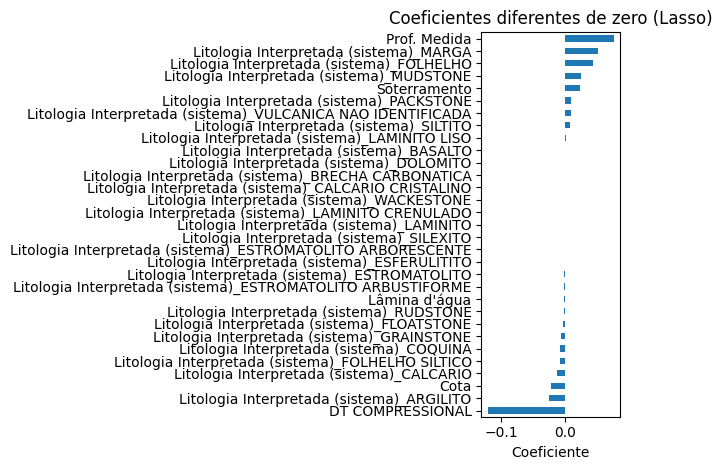

In [ ]:
coef[coef != 0].sort_values().plot(kind="barh", title="Coeficientes diferentes de zero (Lasso)")
plt.xlabel("Coeficiente")
plt.tight_layout()
plt.show()

In [ ]:
# Organizar coeficientes em ordem decrescente de valor absoluto
coef_abs_sorted = coef.abs().sort_values(ascending=False)

# Criar DataFrame para visualizar
coef_df = pd.DataFrame({
    'Coeficiente': coef[coef_abs_sorted.index],  # Coeficientes ordenados
    'Magnitude': coef_abs_sorted,  # Magnitude (valor absoluto)
    'Zerado': coef[coef_abs_sorted.index] == 0  # Indica se o coeficiente foi zerado
})

# Exibir a tabela ordenada
print(coef_df)

                                                    Coeficiente  Magnitude  \
DT COMPRESSIONAL                                      -0.121413   0.121413   
Prof. Medida                                           0.076235   0.076235   
Litologia Interpretada (sistema)_MARGA                 0.051999   0.051999   
Litologia Interpretada (sistema)_FOLHELHO              0.043993   0.043993   
Litologia Interpretada (sistema)_ARGILITO             -0.025428   0.025428   
Litologia Interpretada (sistema)_MUDSTONE              0.024870   0.024870   
Soterramento                                           0.023810   0.023810   
Cota                                                  -0.022300   0.022300   
Litologia Interpretada (sistema)_CALCARIO             -0.012936   0.012936   
Litologia Interpretada (sistema)_PACKSTONE             0.009843   0.009843   
Litologia Interpretada (sistema)_VULCANICA NAO ...     0.008600   0.008600   
Litologia Interpretada (sistema)_FOLHELHO SILTICO     -0.008570 

## Lasso considerando somente variáveis numéricas

Coeficientes Lasso (≠ 0):
DT COMPRESSIONAL   -0.137157
Cota               -0.059787
dtype: float64


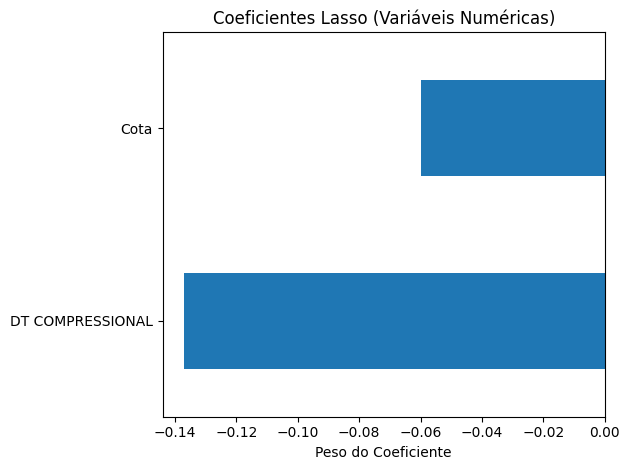

In [ ]:
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Copia da base original (suponha que 'dataset' é o DataFrame carregado)
df_lasso = numeric_dataset.copy()

# Separa variável alvo (DENSIDADE) e preditoras
X = df_lasso.drop(columns=['DENSIDADE'])
y = df_lasso['DENSIDADE']

# Cria pipeline: padronização + Lasso com validação cruzada
pipeline = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42))

# Treina o modelo
pipeline.fit(X, y)

# Extrai modelo treinado de dentro do pipeline
modelo_lasso = pipeline.named_steps['lassocv']

# Extrai os coeficientes
coef = pd.Series(modelo_lasso.coef_, index=X.columns)

# Exibe os coeficientes diferentes de zero
print("Coeficientes Lasso (≠ 0):")
print(coef[coef != 0])

# Visualiza os coeficientes
coef[coef != 0].sort_values().plot(kind='barh', title='Coeficientes Lasso (Variáveis Numéricas)')
plt.xlabel("Peso do Coeficiente")
plt.tight_layout()
plt.show()


In [ ]:
# Organizar coeficientes em ordem decrescente de valor absoluto
coef_abs_sorted = coef.abs().sort_values(ascending=False)

# Criar DataFrame para visualizar
coef_df = pd.DataFrame({
    'Coeficiente': coef[coef_abs_sorted.index],  # Coeficientes ordenados
    'Magnitude': coef_abs_sorted,  # Magnitude (valor absoluto)
    'Zerado': coef[coef_abs_sorted.index] == 0  # Indica se o coeficiente foi zerado
})

# Exibir a tabela ordenada
print(coef_df)

                  Coeficiente  Magnitude  Zerado
DT COMPRESSIONAL    -0.137157   0.137157   False
Cota                -0.059787   0.059787   False
Prof. Medida         0.000000   0.000000    True
Lâmina d'água        0.000000   0.000000    True
Soterramento         0.000000   0.000000    True


# **Análise com Gardner**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [ ]:
# Equação de Gardner: ρ = a * Vp^b
def gardner(Vp, a, b):
    return a * (Vp ** b)

In [ ]:
# Inicializa dicionário para guardar parâmetros por poço
parametros_por_poco = {}

# Lista única de poços
pocos = dataset["Poço"].unique()

pocos

array(['POÇO09', 'POÇO08', 'POÇO07', 'POÇO10', 'POÇO06', 'POÇO04',
       'POÇO05', 'POÇO01', 'POÇO02', 'POÇO03'], dtype=object)

📦 curve_fit – o que é?

A função curve_fit do módulo scipy.optimize realiza ajuste de curvas não-lineares a partir de uma função arbitrária definida pelo usuário. No nosso caso, a função é gardner(Vp, a, b).

🧱 Estrutura geral de uso:

popt, pcov = curve_fit(funcao_modelo, x_dados, y_dados)

funcao_modelo: sua função matemática que descreve o modelo (ex: gardner)

x_dados: variáveis independentes (aqui, Vp)

y_dados: variáveis dependentes (aqui, rho)

popt: vetor com os melhores parâmetros estimados

pcov: matriz de covariância dos parâmetros, usada para incerteza (omitida com _ neste código)



In [ ]:
# Ajuste com dados de treinamento
df_gardnertrain = dataset[~dataset["Poço"].isin(["POÇO04", "POÇO01"])]
Vp_gardnertrain = 304800 / df_gardnertrain["DT COMPRESSIONAL"].values
rho_gardnertrain = df_gardnertrain["DENSIDADE"].values
popt_train, _ = curve_fit(gardner, Vp_gardnertrain, rho_gardnertrain, maxfev=10000)
a_gardnertrain, b_gardnertrain = popt_train

In [ ]:
# from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
# import numpy as np

# Dicionários para armazenar os resultados
parametros_por_poco = {}
r2_por_poco_ajustado = {}
r2_por_poco_treinamento = {}


for poco in pocos:
    dados_poco = dataset[dataset["Poço"] == poco]
    Vp = 304800 / dados_poco["DT COMPRESSIONAL"]
    rho = dados_poco["DENSIDADE"].values

    try:
        # Ajuste do modelo de Gardner por poço
        popt, _ = curve_fit(gardner, Vp, rho, maxfev=10000)
        a_fit, b_fit = popt
        parametros_por_poco[poco] = {"a": a_fit, "b": b_fit}

        # Previsões
        rho_pred_fit = gardner(Vp, a_fit, b_fit)
        rho_pred_train = gardner(Vp, a_gardnertrain, b_gardnertrain)

        # Cálculo do R²
        r2_fit = r2_score(rho, rho_pred_fit)
        r2_train = r2_score(rho, rho_pred_train)

        r2_por_poco_ajustado[poco] = r2_fit
        r2_por_poco_treinamento[poco] = r2_train

    except RuntimeError:
        print(f"Não foi possível ajustar Gardner para o poço {poco}")
        parametros_por_poco[poco] = {"a": np.nan, "b": np.nan}
        r2_por_poco_ajustado[poco] = np.nan
        r2_por_poco_treinamento[poco] = np.nan

In [ ]:
# Mostra parâmetros calculados
print(f"Parâmetros de Gardner com dados de treinamento: a = {a_gardnertrain:.5f}, b = {b_gardnertrain:.5f}")

# Lista para armazenar os dados
tabela_parametros = []

for poco in sorted(pocos):
    a = parametros_por_poco[poco]["a"]
    b = parametros_por_poco[poco]["b"]
    r2_fit = r2_por_poco_ajustado[poco]
    r2_train = r2_por_poco_treinamento[poco]

    tabela_parametros.append({
        "Poço": poco,
        "a (ajustado)": round(a, 6),
        "b (ajustado)": round(b, 6),
        "R² Ajustado (poço)": round(r2_fit, 4),
        "R² Treinamento": round(r2_train, 4)
    })

# Cria o DataFrame
df_parametros = pd.DataFrame(tabela_parametros)

# # Exibe a tabela ordenada por Poço
# print("\nParâmetros por poço:")
# print(df_parametros.to_string(index=False))


Parâmetros de Gardner com dados de treinamento: a = 0.26553, b = 0.26436


In [ ]:
df = dataset_original.copy()

df.describe()

Poço  Prof. Medida  DENSIDADE  DT COMPRESSIONAL       Cota  \
count   152231     152231.00  119404.00          142021.0  152231.00   
unique      10      94173.00     214.00           12301.0  122690.00   
top     POÇO04       3083.97       2.05             124.0   -2976.82   
freq     23785          7.00    5089.00             496.0       4.00   

             TVD Litologia Interpretada (sistema)  Lâmina d'água  Soterramento  
count   152231.0                           152231       152231.0     152231.00  
unique  113313.0                               32           10.0     130386.00  
top       3197.2                           HALITA         1751.0        757.55  
freq         6.0                            47807        23785.0          5.00

# **Início dos Modelos**

## **Criação de colunas Dummies**

In [ ]:
!pip install fast_ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.7 MB/s eta 0:00:00


In [ ]:
## Colunas Dummies para todas as litologias

# Copiar o DataFrame original
df = dataset.copy()

# Criar dummies diretamente da coluna original
df_dummies = pd.get_dummies(df["Litologia Interpretada (sistema)"], prefix='lito')

# Concatenar os dummies ao DataFrame original e remover a coluna original
df = pd.concat([df, df_dummies], axis=1)

df

Poço Prof. Medida DENSIDADE DT COMPRESSIONAL     Cota  \
0       POÇO09       2856.0      2.64           117.43 -2828.81   
1       POÇO09      2856.15      2.35           115.93 -2828.96   
2       POÇO09       2856.3      1.84           115.66 -2829.11   
3       POÇO09      2856.46      1.78           116.73 -2829.27   
4       POÇO09      2856.61      1.84           118.79 -2829.42   
...        ...          ...       ...              ...      ...   
152174  POÇO03      6017.21      2.46            59.06 -5945.61   
152175  POÇO03      6017.36      2.47            59.19 -5945.76   
152176  POÇO03      6017.51      2.47            59.36 -5945.91   
152177  POÇO03      6017.67      2.48            59.45 -5946.07   
152178  POÇO03      6017.82      2.48            59.51 -5946.22   

       Litologia Interpretada (sistema) Lâmina d'água Soterramento  \
0                              FOLHELHO        1888.0       940.81   
1                              FOLHELHO        1888.0       940.96   
2                              FOLHELHO        1888.0       941.11   
3                              FOLHELHO        1888.0       941.27   
4                              FOLHELHO        1888.0       941.42   
...                                 ...           ...          ...   
152174                          COQUINA        2136.0      3809.61   
152175                          COQUINA        2136.0      3809.76   
152176                          COQUINA        2136.0      3809.91   
152177                          COQUINA        2136.0      3810.07   
152178                          COQUINA        2136.0      3810.22   

        lito_ARENITO  lito_ARGILITO  ...  lito_LAMINITO CRENULADO  \
0              False          False  ...                    False   
1              False          False  ...                    False   
2              False          False  ...                    False   
3              False          False  ...                    False   
4              False          False  ...                    False   
...              ...            ...  ...                      ...   
152174         False          False  ...                    False   
152175         False          False  ...                    False   
152176         False          False  ...                    False   
152177         False          False  ...                    False   
152178         False          False  ...                    False   

        lito_LAMINITO LISO  lito_MARGA  lito_MUDSTONE  lito_PACKSTONE  \
0                    False       False          False           False   
1                    False       False          False           False   
2                    False       False          False           False   
3                    False       False          False           False   
4                    False       False          False           False   
...                    ...         ...            ...             ...   
152174               False       False          False           False   
152175               False       False          False           False   
152176               False       False          False           False   
152177               False       False          False           False   
152178               False       False          False           False   

        lito_RUDSTONE  lito_SILEXITO  lito_SILTITO  \
0               False          False         False   
1               False          False         False   
2               False          False         False   
3               False          False         False   
4               False          False         False   
...               ...            ...           ...   
152174          False          False         False   
152175          False          False         False   
152176          False          False         False   
152177          False          False         False   
152178          False          False         False   

        l

## **Divisão de dados em conjuntos de treinamento, Teste 1 e Teste 2**

In [ ]:
# Subconjuntos por poço
df_test1 = df[df["Poço"] == "POÇO04"]
df_test2  = df[df["Poço"] == "POÇO01"]
df_train = df[~df["Poço"].isin(["POÇO04", "POÇO01"])]


In [ ]:
# Seleciona só as colunas de entrada na hora de criar X
X_train = df_train.drop(columns=["DENSIDADE", "Poço", "Cota", "Lâmina d'água", "Litologia Interpretada (sistema)", 'Prof. Medida'])
y_train = df_train["DENSIDADE"]

X_test1 = df_test1.drop(columns=["DENSIDADE", "Poço", "Cota", "Lâmina d'água", "Litologia Interpretada (sistema)", 'Prof. Medida'])
y_test1 = df_test1["DENSIDADE"]

X_test2  = df_test2.drop(columns=["DENSIDADE", "Poço", "Cota", "Lâmina d'água", "Litologia Interpretada (sistema)", 'Prof. Medida'])
y_test2  = df_test2["DENSIDADE"]


In [ ]:
print("Variáveis selecionadas para X:")

print("X_train:", X_train.columns.tolist())
print(f"Número de variáveis em X_train: {len(X_train.columns)}")

print("X_test1:", X_test1.columns.tolist())
print(f"Número de variáveis em X_test1: {len(X_test1.columns)}")

print("X_test2:", X_test2.columns.tolist())
print(f"Número de variáveis em X_test2: {len(X_test2.columns)}")


Variáveis selecionadas para X:
X_train: ['DT COMPRESSIONAL', 'Soterramento', 'lito_ARENITO', 'lito_ARGILITO', 'lito_BASALTO', 'lito_BRECHA CARBONATICA', 'lito_CALCARIO', 'lito_CALCARIO CRISTALINO', 'lito_COQUINA', 'lito_DOLOMITO', 'lito_ESFERULITITO', 'lito_ESTROMATOLITO', 'lito_ESTROMATOLITO ARBORESCENTE', 'lito_ESTROMATOLITO ARBUSTIFORME', 'lito_FLOATSTONE', 'lito_FOLHELHO', 'lito_FOLHELHO SILTICO', 'lito_GRAINSTONE', 'lito_LAMINITO', 'lito_LAMINITO CRENULADO', 'lito_LAMINITO LISO', 'lito_MARGA', 'lito_MUDSTONE', 'lito_PACKSTONE', 'lito_RUDSTONE', 'lito_SILEXITO', 'lito_SILTITO', 'lito_VULCANICA NAO IDENTIFICADA', 'lito_WACKESTONE']
Número de variáveis em X_train: 29
X_test1: ['DT COMPRESSIONAL', 'Soterramento', 'lito_ARENITO', 'lito_ARGILITO', 'lito_BASALTO', 'lito_BRECHA CARBONATICA', 'lito_CALCARIO', 'lito_CALCARIO CRISTALINO', 'lito_COQUINA', 'lito_DOLOMITO', 'lito_ESFERULITITO', 'lito_ESTROMATOLITO', 'lito_ESTROMATOLITO ARBORESCENTE', 'lito_ESTROMATOLITO ARBUSTIFORME', 'lito_FLO

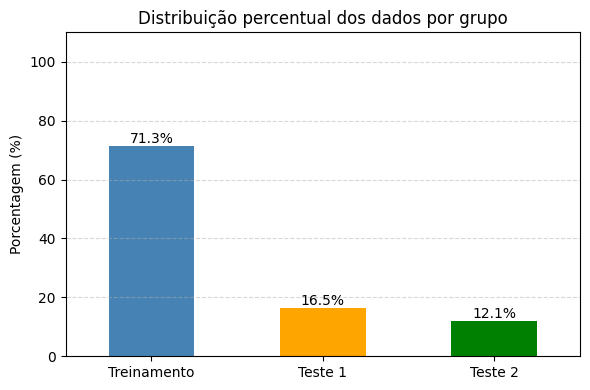

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Conta o número de registros em cada conjunto
n_train = len(X_train)
n_test1 = len(X_test1)
n_test2 = len(X_test2)
n_total = n_train + n_test1 + n_test2

# Calcula as porcentagens
porcentagens = {
    "Treinamento": n_train / n_total * 100,
    "Teste 1": n_test1 / n_total * 100,
    "Teste 2": n_test2 / n_total * 100
}

# Converte para DataFrame
df_pct = pd.DataFrame.from_dict(porcentagens, orient='index', columns=["Porcentagem"])

# Cria gráfico de barras
plt.figure(figsize=(6, 4))
bars = df_pct["Porcentagem"].plot(kind="bar", color=["steelblue", "orange", "green"])

# Adiciona os valores sobre cada barra
for i, v in enumerate(df_pct["Porcentagem"]):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)

plt.ylabel("Porcentagem (%)")
plt.title("Distribuição percentual dos dados por grupo")
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



Normalização dos Dados de Treinamento

In [ ]:
# Normalização dos Dados de treinamento

from sklearn.preprocessing import MinMaxScaler

# Dados entrada treinamento

scaler1 = MinMaxScaler(feature_range = (0,1))
scaled_data1 = scaler1.fit_transform(X_train) #Normalizar cada variável segundo seu mínimo e máximo. O resultado scaled_data1 é um novo array onde cada coluna está no intervalo [0, 1]
train_entn = scaled_data1
#print(train_entn) #Valores de entrada normalizados

In [ ]:
# Dados saída treinamento
import numpy as np
y_train_array = pd.DataFrame(np.array(y_train)) #Transforma y_train em um DataFrame do pandas, garantindo que fique no formato 2D esperado pelo MinMaxScaler
scaler2 = MinMaxScaler(feature_range = (0,1))
scaled_data2 = scaler2.fit_transform(y_train_array)
train_sain = np.ravel(scaled_data2) #Trocar a dimensão do vetor condição necessária para rodar o modelo.
#print(train_sain) #Valores de saída normalizados

In [ ]:
# Dados entrada teste 1
test1_entn = scaler1.transform(X_test1) #Normalizar cada variável segundo seu mínimo e máximo.

# Dados entrada teste
test2_entn = scaler1.transform(X_test2) #Normalizar cada variável segundo seu mínimo e máximo.

In [ ]:
df_test1

Poço Prof. Medida DENSIDADE DT COMPRESSIONAL     Cota  \
73327  POÇO04      2576.78      1.35           143.56 -2551.78   
73328  POÇO04      2576.93      1.35           139.37 -2551.93   
73329  POÇO04      2577.08      1.39           135.34 -2552.08   
73330  POÇO04      2577.24      1.44            128.2 -2552.24   
73331  POÇO04      2577.39      1.47           126.92 -2552.39   
...       ...          ...       ...              ...      ...   
97027  POÇO04      6188.66      2.67            57.79  -6163.6   
97028  POÇO04      6188.81      2.65            58.02 -6163.75   
97029  POÇO04      6188.96      2.63            58.22  -6163.9   
97030  POÇO04      6189.12       2.6            58.34 -6164.06   
97031  POÇO04      6189.27      2.61            58.39 -6164.21   

      Litologia Interpretada (sistema) Lâmina d'água Soterramento  \
73327                         FOLHELHO        1751.0       800.78   
73328                         FOLHELHO        1751.0       800.93   
73329                         FOLHELHO        1751.0       801.08   
73330                         FOLHELHO        1751.0       801.24   
73331                         FOLHELHO        1751.0       801.39   
...                                ...           ...          ...   
97027                         FOLHELHO        1751.0       4412.6   
97028                          COQUINA        1751.0      4412.75   
97029                          COQUINA        1751.0       4412.9   
97030                          COQUINA        1751.0      4413.06   
97031                          COQUINA        1751.0      4413.21   

       lito_ARENITO  lito_ARGILITO  ...  lito_LAMINITO CRENULADO  \
73327         False          False  ...                    False   
73328         False          False  ...                    False   
73329         False          False  ...                    False   
73330         False          False  ...                    False   
73331         False          False  ...                    False   
...             ...            ...  ...                      ...   
97027         False          False  ...                    False   
97028         False          False  ...                    False   
97029         False          False  ...                    False   
97030         False          False  ...                    False   
97031         False          False  ...                    False   

       lito_LAMINITO LISO  lito_MARGA  lito_MUDSTONE  lito_PACKSTONE  \
73327               False       False          False           False   
73328               False       False          False           False   
73329               False       False          False           False   
73330               False       False          False           False   
73331               False       False          False           False   
...                   ...         ...            ...             ...   
97027               False       False          False           False   
97028               False       False          False           False   
97029               False       False          False           False   
97030               False       False          False           False   
97031               False       False          False           False   

       lito_RUDSTONE  lito_SILEXITO  lito_SILTITO  \
73327          False          False         False   
73328          False          False         False   
73329          False          False         False   
73330          False          False         False   
73331          False          False         False   
...              ...            ...           ...   
97027          False          False         False   
97028          False          False         False   
97029          False          False         False   
97030          False          False         False   
97031          False          False         False   

       lito_VULCANICA NAO IDENTIFICADA  lito_WACKESTONE  
73327     

## **Funções de Avaliação do Modelo**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

# Dicionário de litologias com cores e hachuras
litologias_dict = {
    "FOLHELHO": {"cor": "#40ff00", "hatch": ""},
    "MARGA": {"cor": "#300fff", "hatch": ""},
    "ARENITO": {"cor": "#ffff40", "hatch": "."},
    "MUDSTONE": {"cor": "#4fffff", "hatch": ""},
    "PACKSTONE": {"cor": "#1ab3f2", "hatch": ""},
    "ANIDRITA": {"cor": "#de1fff", "hatch": "/"},
    "HALITA": {"cor": "#6eb0cf", "hatch": "x"},
    "CARNALITA": {"cor": "#b05ede", "hatch": "."},
    "TAQUIDRITA": {"cor": "#6e1fde", "hatch": "."},
    "SILVINITA": {"cor": "#cfa1de", "hatch": "."},
    "CALCARIO": {"cor": "#bfffff", "hatch": ""},
    "LAMINITO CRENULADO": {"cor": "#5278ba", "hatch": ""},
    "GRAINSTONE": {"cor": "#0080ed", "hatch": ""},
    "LAMINITO LISO": {"cor": "#5278ba", "hatch": ""},
    "ESTROMATOLITO ARBORESCENTE": {"cor": "#5278ba", "hatch": ""},
    "BRECHA CARBONATICA": {"cor": "#00b0ff", "hatch": ""},
    "ESFERULITITO": {"cor": "#5278ba", "hatch": ""},
    "ESTROMATOLITO ARBUSTIFORME": {"cor": "#5278ba", "hatch": ""},
    "CALCARIO CRISTALINO": {"cor": "#00eded", "hatch": ""},
    "RUDSTONE": {"cor": "#00b0ff", "hatch": ""},
    "DOLOMITO": {"cor": "#00bfcf", "hatch": ""},
    "LAMINITO": {"cor": "#5278ba", "hatch": ""},
    "ARGILITO": {"cor": "#80ff00", "hatch": ""},
    "WACKESTONE": {"cor": "#33d9fa", "hatch": ""},
    "COQUINA": {"cor": "#b0eded", "hatch": ""},
    "SILTITO": {"cor": "#b01f4f", "hatch": ""},
    "ESTROMATOLITO": {"cor": "#5278ba", "hatch": ""},
    "SILEXITO": {"cor": "#bfffff", "hatch": ""},
    "FLOATSTONE": {"cor": "#80ffff", "hatch": ""},
    "BASALTO": {"cor": "#ff00ff", "hatch": ""},
    "VULCANICA NAO IDENTIFICADA": {"cor": "#ff0000", "hatch": ""},
    "FOLHELHO SILTICO": {"cor": "#40ff00", "hatch": ""},
}

In [ ]:
def agrupar_intervalos(df_poco):
    intervalos = []
    if df_poco.empty:
        return intervalos

    # Ordena o DataFrame pela coluna 'COTA' (valores mais negativos representam maior profundidade)
    df_poco = df_poco.sort_values(by='Cota').reset_index(drop=True)

    # Inicializa as variáveis para o primeiro intervalo
    lit_atual = df_poco.loc[0, 'Litologia Interpretada (sistema)']
    cota_topo = df_poco.loc[0, 'Cota']

    # Itera sobre as linhas do DataFrame
    for i in range(1, len(df_poco)):
        lit = df_poco.loc[i, 'Litologia Interpretada (sistema)']
        cota = df_poco.loc[i, 'Cota']

        # Quando a litologia muda, adiciona o intervalo e atualiza as variáveis
        if lit != lit_atual:
            intervalos.append((cota_topo, cota, lit_atual))
            lit_atual = lit
            cota_topo = cota

    # Adiciona o último intervalo
    intervalos.append((cota_topo, df_poco.loc[len(df_poco) - 1, 'Cota'], lit_atual))

    return intervalos


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def avaliar_modelo_regressao(y_predito, df_modelo, titulo='Resultado da Regressão', nome_modelo='Modelo', tipo_dado='NomeConjDados'):
    # Recupera valores reais e DTC
    y_real = df_modelo["DENSIDADE"]
    dtc = df_modelo["DT COMPRESSIONAL"]

    # Máscara para ignorar valores NaN (necessária para y_predito incompleto)
    mascara_validos = ~np.isnan(y_predito)

    # Aplica máscara
    y_real_valid = y_real[mascara_validos]
    dtc_valid = dtc[mascara_validos]
    y_predito_valid = y_predito[mascara_validos]

    # Curva Gardner global
    DT_gardner_global = np.linspace(dtc.min(), dtc.max(), 200)
    Vp_gardner_global = 304800 / DT_gardner_global
    rho_gardner_train = gardner(Vp_gardner_global, a_gardnertrain, b_gardnertrain)

    # Gráfico
    # Cria dois subplots lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [3, 2]})

    # --- Gráfico 1: Densidade vs DTC ---
    ax1.scatter(dtc_valid, y_real_valid, label=f"Dados Reais - {tipo_dado}", alpha=0.6)

    if nome_modelo == "Gardner":
        ax1.plot(DT_gardner_global, rho_gardner_train, color='black',
                label=f"Gardner calibrado com dados de treinamento\n(a={a_gardnertrain:.4f}, b={b_gardnertrain:.4f})")
    else:
        ax1.plot(DT_gardner_global, rho_gardner_train, color='black',
                label=f"Gardner calibrado com dados de treinamento\n(a={a_gardnertrain:.4f}, b={b_gardnertrain:.4f})")
        ax1.scatter(dtc_valid, y_predito, label=f"Predição - {titulo}", alpha=0.6)

    ax1.set_xlabel("DT Compressional (us/ft)")
    ax1.set_ylabel("Densidade (g/cm³)")
    ax1.set_title("Densidade vs DT Compressional")
    ax1.grid(True)
    ax1.legend(fontsize=8)

    # --- Gráfico 2: Densidade Observada vs Predita ---
    ax2.scatter(y_real_valid, y_predito_valid, alpha=0.6, color='green', label='Predições')
    min_val = min(y_real_valid.min(), y_predito_valid.min())
    max_val = max(y_real_valid.max(), y_predito_valid.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'k--', label='x = y')

    ax2.set_xlabel("Densidade Observada (g/cm³)")
    ax2.set_ylabel("Densidade Predita (g/cm³)")
    ax2.set_title("Predito vs Observado")
    ax2.grid(True)
    ax2.legend(fontsize=8)

    # Título geral e layout
    fig.suptitle(titulo, fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Deixa espaço pro título
    plt.show()


    # Métricas
    r2 = r2_score(y_real_valid, y_predito_valid)
    mse = mean_squared_error(y_real_valid, y_predito_valid)
    sse = mse * len(y_real_valid)

    print(f"Métricas - {titulo}")
    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"SSE: {sse:.4f}")

    # Cria nome da coluna para predição e adiciona ao DataFrame
    nome_coluna_predita = f"DENSIDADE_{nome_modelo}"
    df_modelo[nome_coluna_predita] = y_predito

    # Retorna DataFrame com as métricas
    metricas_df = pd.DataFrame([{
        "Modelo": nome_modelo,
        "Tipo de Dado": tipo_dado,
        "R²": r2,
        "MSE": mse,
        "SSE": sse
    }])

    return df_modelo, metricas_df

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plotar_litologia_e_densidade_Modelo(df_poco, dados_modelo):
    intervalos = agrupar_intervalos(df_poco)

    nome_poco = df_poco['Poço'].iloc[0]

        # Recuperar o título e a legenda do modelo
    titulo_grafico = dados_modelo.get('titulo_grafico', 'Resultado da Regressão')
    legenda_modelo = dados_modelo.get('legenda_modelo', 'Curva do Modelo')

    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(4, 10), sharey=True, gridspec_kw={'width_ratios': [1, 2]}
    )

    litologias_presentes = set()

    # Plot coluna litológica
    for top, base, lit in intervalos:
        if base <= top:
            continue
        props = litologias_dict.get(lit, {"cor": "#FFFFFF", "hatch": ""})
        rect = patches.Rectangle(
            (0, top), 1, base - top,
            facecolor=props["cor"],
            edgecolor='black',
            hatch=props["hatch"],
            linewidth=0.2
        )
        ax1.add_patch(rect)
        litologias_presentes.add(lit)

    # Dados Gardner
    DT = dados_modelo['DT COMPRESSIONAL'].values
    Vp = 304800 / DT
    cota_gardner = dados_modelo['Cota'].values

    rho_gardner_train = np.full_like(Vp, np.nan, dtype=float)
    rho_gardner_train = gardner(Vp, a_gardnertrain, b_gardnertrain)

    # Configurações do eixo litologia
    ax1.set_xlim(0, 1)
    if not df_poco.empty:
        ax1.set_ylim(df_poco['Cota'].min(), df_poco['Cota'].max())
    else:
        ax1.set_ylim(0, 100)
    ax1.set_xticks([])
    ax1.set_title('Litologia', fontsize=9)
    ax1.set_ylabel('Cota (m)', fontsize=9)
    ax1.get_xaxis().set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    densidade_modelo = dados_modelo['DENSIDADE']
    cota_modelo = dados_modelo['Cota']

    # Curvas densidade no eixo 2
    ax2.plot(df_poco['DENSIDADE'], df_poco['Cota'], color='blue', marker='.', linestyle='None',
             markersize=2, label='Densidade medida')
    ax2.plot(rho_gardner_train, cota_gardner, color='black', marker='.', linestyle='None',
             markersize=2, label=f"Gardner ajustado para dados de treinamento\n(a={a_gardnertrain:.4f}, b={b_gardnertrain:.4f})")
    ax2.plot(densidade_modelo, cota_modelo, color='green', marker='.', linestyle='None',
               markersize=2, label=f'Previsão Modelo {legenda_modelo}')

    ax2.set_xlim(1.5, 3.5)
    ax2.grid(True, linestyle='--', linewidth=0.5)
    ax2.set_title('Densidade', fontsize=9)

    fig.suptitle(f'{titulo_grafico}', fontsize=10)

    # Legenda litologias
    handles_lito = []
    for lit in sorted(list(litologias_presentes)):
        props = litologias_dict[lit]
        patch = patches.Patch(
            facecolor=props["cor"],
            hatch=props["hatch"],
            edgecolor='black',
            label=lit,
            linewidth=0.8
        )
        handles_lito.append(patch)

    # Legendas curvas e litologias juntas
    handles_curvas, labels_curvas = ax2.get_legend_handles_labels()

    fig.legend(
        handles_lito + handles_curvas,
        [h.get_label() for h in handles_lito] + labels_curvas,
        loc='upper left',
        bbox_to_anchor=(1.05, 0.85),
        fontsize=7,
        title='Litologia e Curvas'
    )

    plt.tight_layout()
    plt.show()

## **Gardner**

In [ ]:
#Calculando Densidade por Gardner com parâmetros usando somente dados do treinamento

Vp_train = 304800 / df_train["DT COMPRESSIONAL"]
Vp_test1 = 304800 / df_test1["DT COMPRESSIONAL"]
Vp_test2 = 304800 / df_test2["DT COMPRESSIONAL"]

rho_gardner_train = gardner(Vp_train, a_gardnertrain, b_gardnertrain)
rho_gardner_test1 = gardner(Vp_test1, a_gardnertrain, b_gardnertrain)
rho_gardner_test2 = gardner(Vp_test2, a_gardnertrain, b_gardnertrain)

# Garantir que os valores estão como float
rho_gardner_train = np.array(rho_gardner_train, dtype=float)
rho_gardner_test1 = np.array(rho_gardner_test1, dtype=float)
rho_gardner_test2 = np.array(rho_gardner_test2, dtype=float)


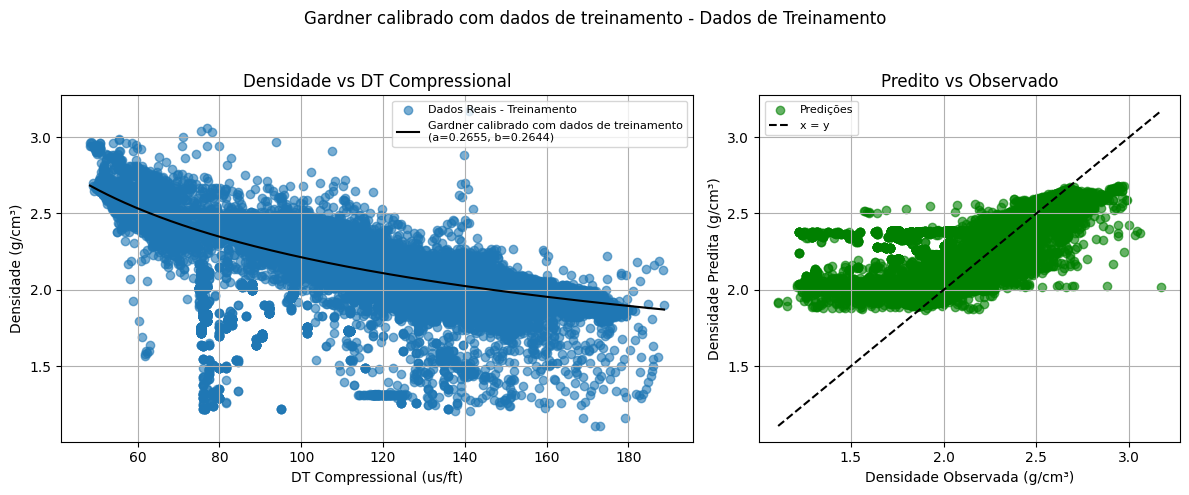

Métricas - Gardner calibrado com dados de treinamento - Dados de Treinamento
R²: 0.6655
MSE: 0.0180
SSE: 1037.3501


/tmp/ipython-input-42-26961262.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_train, met_gardner_train = avaliar_modelo_regressao(rho_gardner_train, df_train, titulo= 'Gardner calibrado com dados de treinamento - Dados de Treinamento',
                                                       nome_modelo = "Gardner", tipo_dado = "Treinamento")

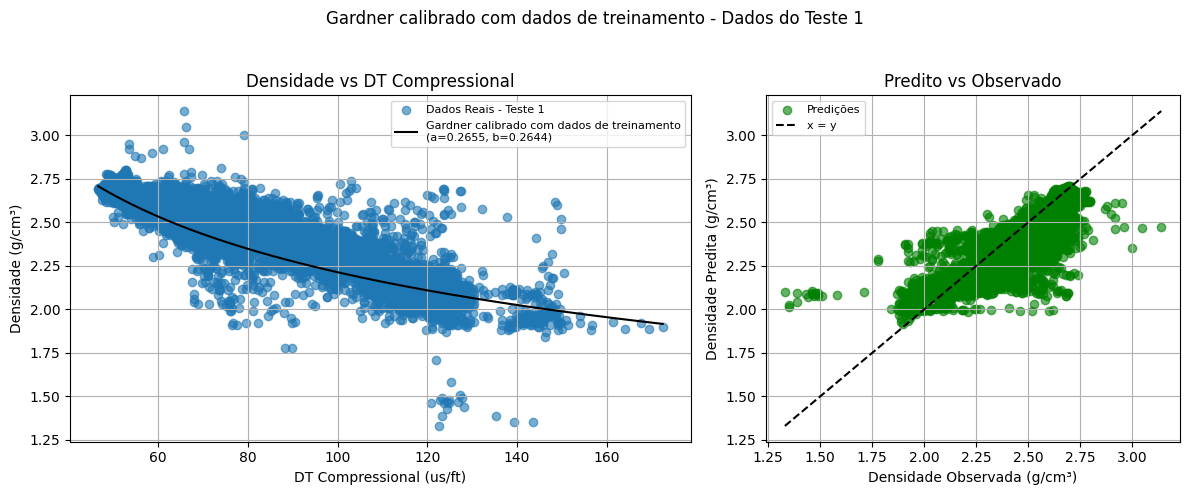

Métricas - Gardner calibrado com dados de treinamento - Dados do Teste 1
R²: 0.7259
MSE: 0.0140
SSE: 187.0401


/tmp/ipython-input-42-26961262.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_test1, met_gardner_test1 = avaliar_modelo_regressao(rho_gardner_test1, df_test1, titulo= 'Gardner calibrado com dados de treinamento - Dados do Teste 1',
                                                       nome_modelo = "Gardner", tipo_dado = "Teste 1")

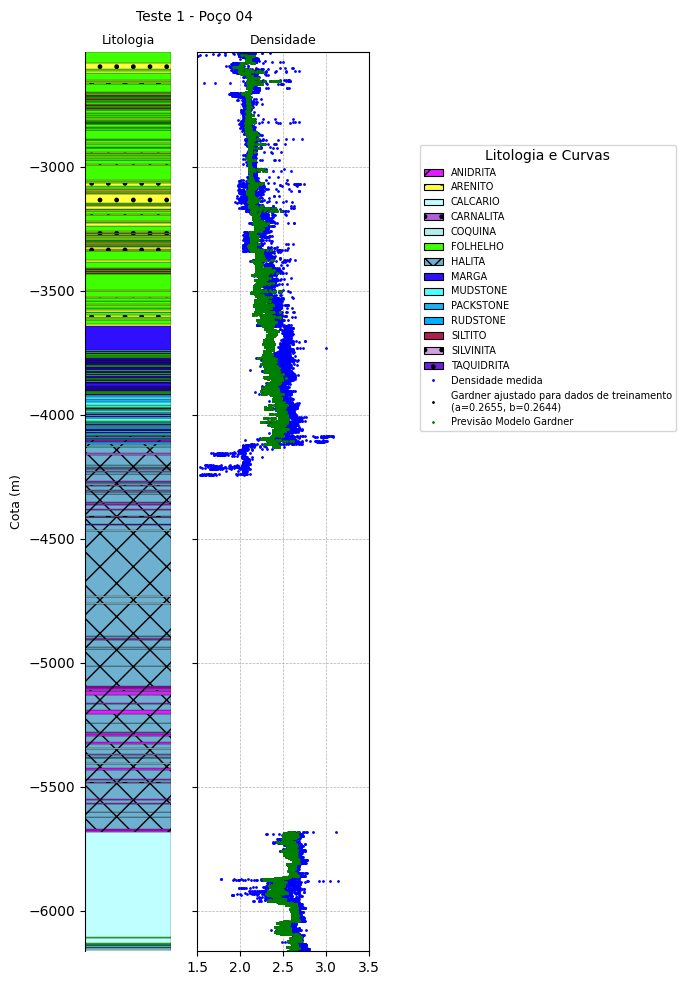

In [ ]:
dados_test1_Gardner = {
    'DENSIDADE': rho_gardner_test1,
    'Cota': df_test1["Cota"],
    'DT COMPRESSIONAL': df_test1["DT COMPRESSIONAL"],
    'titulo_grafico': 'Teste 1 - Poço 04',
    'legenda_modelo': 'Gardner'
}

pocotest1 = df_test1['Poço'].iloc[0]

plotar_litologia_e_densidade_Modelo(
    dataset_original[dataset_original['Poço'] == pocotest1],
    dados_test1_Gardner
)

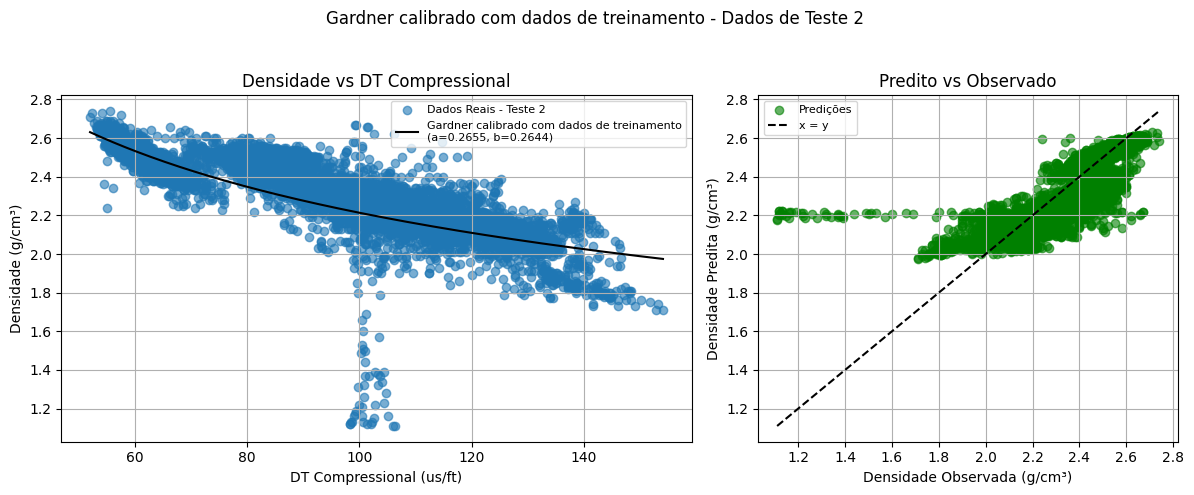

Métricas - Gardner calibrado com dados de treinamento - Dados de Teste 2
R²: 0.6306
MSE: 0.0138
SSE: 135.1349


/tmp/ipython-input-42-26961262.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_test2, met_gardner_test = avaliar_modelo_regressao(rho_gardner_test2, df_test2, titulo= 'Gardner calibrado com dados de treinamento - Dados de Teste 2',
                                                     nome_modelo = "Gardner", tipo_dado = "Teste 2")

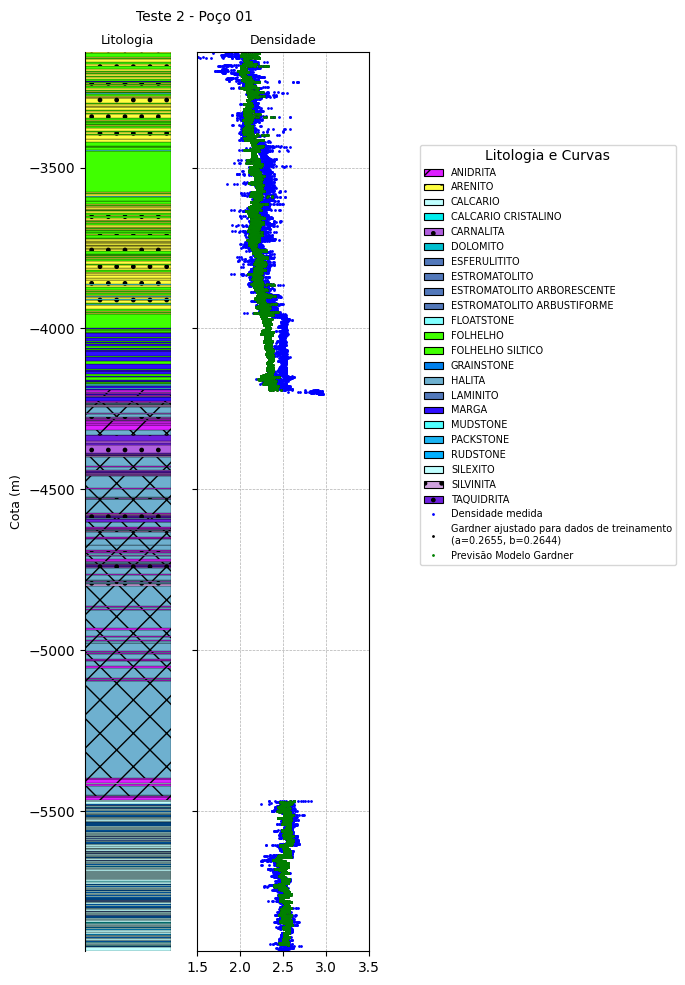

In [ ]:
dados_test2_Gardner = {
    'DENSIDADE': rho_gardner_test2,
    'Cota': df_test2["Cota"],
    'DT COMPRESSIONAL': df_test2["DT COMPRESSIONAL"],
    'titulo_grafico': 'Teste 2 - Poço 01',
    'legenda_modelo': 'Gardner'
}

pocotest2 = df_test2['Poço'].iloc[0]

plotar_litologia_e_densidade_Modelo(
    dataset_original[dataset_original['Poço'] == pocotest2],
    dados_test2_Gardner
)

# **SVR**



## **Seleção de Topologia**

In [ ]:
from sklearn import svm

ModeloSVM = svm.SVR() #cria um objeto

In [ ]:
parametrosSVM = [{'C':[0.2,0.5,1],
               'kernel':["linear","sigmoid","rbf", "poly"]}]

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=ModeloSVM,
                    param_grid=parametrosSVM,
                    cv=5,
                    verbose=2)
grid.fit(train_entn, train_sain)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...............................C=0.2, kernel=linear; total time= 2.0min
[CV] END ...............................C=0.2, kernel=linear; total time=  10.3s
[CV] END ...............................C=0.2, kernel=linear; total time= 2.6min
[CV] END ...............................C=0.2, kernel=linear; total time=   6.1s
[CV] END ...............................C=0.2, kernel=linear; total time= 3.0min
[CV] END ..............................C=0.2, kernel=sigmoid; total time=13.9min
[CV] END ..............................C=0.2, kernel=sigmoid; total time=12.3min
[CV] END ..............................C=0.2, kernel=sigmoid; total time= 9.4min
[CV] END ..............................C=0.2, kernel=sigmoid; total time= 9.6min
[CV] END ..............................C=0.2, kernel=sigmoid; total time= 9.8min
[CV] END ..................................C=0.2, kernel=rbf; total time=   9.9s
[CV] END ..................................C=0.2

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.2, 0.5, 1],
                          'kernel': ['linear', 'sigmoid', 'rbf', 'poly']}],
             verbose=2)

In [ ]:
pd.DataFrame(grid.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0       94.665112     73.625024         0.970500        0.419572      0.2   
1      613.123806    106.109405        46.078560        0.605252      0.2   
2       45.505424     78.571188         2.167842        0.691553      0.2   
3       72.636108     83.784271         0.941386        0.171295      0.2   
4        8.887070      1.630079         0.982608        0.330190      0.5   
5      476.678307     77.139181        46.319935        0.799749      0.5   
6       91.961111    104.682641         1.709999        0.497624      0.5   
7       58.576042     64.463035         0.870976        0.286061      0.5   
8        8.858486      2.509862         1.051013        0.360082      1.0   
9      541.735479    157.459212        46.659971        0.741126      1.0   
10      75.203387     84.933715         1.760326        0.409469      1.0   
11      44.111271     73.770027         0.737825        0.142979      1.0   

   param_kernel                           params  split0_test_score  \
0        linear   {'C': 0.2, 'kernel': 'linear'}           0.821577   
1       sigmoid  {'C': 0.2, 'kernel': 'sigmoid'}      -31683.962355   
2           rbf      {'C': 0.2, 'kernel': 'rbf'}           0.781990   
3          poly     {'C': 0.2, 'kernel': 'poly'}           0.763371   
4        linear   {'C': 0.5, 'kernel': 'linear'}           0.821729   
5       sigmoid  {'C': 0.5, 'kernel': 'sigmoid'}     -197767.832477   
6           rbf      {'C': 0.5, 'kernel': 'rbf'}           0.780552   
7          poly     {'C': 0.5, 'kernel': 'poly'}           0.739586   
8        linear     {'C': 1, 'kernel': 'linear'}           0.821493   
9       sigmoid    {'C': 1, 'kernel': 'sigmoid'}     -791378.393822   
10          rbf        {'C': 1, 'kernel': 'rbf'}           0.784959   
11         poly       {'C': 1, 'kernel': 'poly'}           0.718688   

    split1_test_score  split2_test_score  split3_test_score  \
0        1.726753e-01       7.809896e-01       2.791966e-01   
1       -4.939785e+05      -6.164211e+04      -6.139521e+04   
2        7.090533e-02       7.705362e-01       2.621507e-01   
3       -5.971105e-02       7.695858e-01      -9.646785e-02   
4        1.686358e-01       7.812149e-01       2.712501e-01   
5       -3.082355e+06      -3.856312e+05      -3.838904e+05   
6        9.218189e-02       7.677927e-01       2.775076e-01   
7        5.232811e-02       7.660445e-01      -1.633023e-01   
8        1.739416e-01       7.809921e-01       2.738989e-01   
9       -1.232949e+07      -1.543550e+06      -1.535742e+06   
10       6.148561e-02       7.555544e-01       2.500024e-01   
11       1.019534e-02       7.510911e-01      -2.373068e-01   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
0        3.803810e-01     4.869638e-01    2.652249e-01                1  
1       -8.068149e+04    -1.458763e+05    1.747558e+05               10  
2        3.307550e-01     4.432675e-01    2.849399e-01                5  
3        2.360462e-01     3.225648e-01    3.803542e-01                7  
4        3.789957e-01     4.843652e-01    2.676341e-01                3  
5       -5.032461e+05    -9.105781e+05    1.090285e+06               11  
6        3.254619e-01     4.486992e-01    2.769642e-01                4  
7        1.868578e-01     3.163029e-01    3.736031e-01                8  
8        3.824273e-01     4.865505e-01    2.655820e-01                2  
9       -2.013470e+06    -3.642726e+06    4.360974e+06               12  
10       3.277906e-01     4.359585e-01    2.865146e-01                6  
11       1.901975e-01     2.865730e-01    3.905440e-01                9

In [ ]:
resultados = pd.DataFrame(grid.cv_results_)[['params','rank_test_score','mean_test_score']]
resultados = resultados.sort_values(by='rank_test_score')
resultados

params  rank_test_score  mean_test_score
0    {'C': 0.2, 'kernel': 'linear'}                1     4.869638e-01
8      {'C': 1, 'kernel': 'linear'}                2     4.865505e-01
4    {'C': 0.5, 'kernel': 'linear'}                3     4.843652e-01
6       {'C': 0.5, 'kernel': 'rbf'}                4     4.486992e-01
2       {'C': 0.2, 'kernel': 'rbf'}                5     4.432675e-01
10        {'C': 1, 'kernel': 'rbf'}                6     4.359585e-01
3      {'C': 0.2, 'kernel': 'poly'}                7     3.225648e-01
7      {'C': 0.5, 'kernel': 'poly'}                8     3.163029e-01
11       {'C': 1, 'kernel': 'poly'}                9     2.865730e-01
1   {'C': 0.2, 'kernel': 'sigmoid'}               10    -1.458763e+05
5   {'C': 0.5, 'kernel': 'sigmoid'}               11    -9.105781e+05
9     {'C': 1, 'kernel': 'sigmoid'}               12    -3.642726e+06

In [ ]:
print("Melhores parâmetros:", grid.best_params_)

Melhores parâmetros: {'C': 0.2, 'kernel': 'linear'}


## **Treinamento**

In [ ]:
#Especificar a topologia do modelo

from sklearn import svm

ModeloSVM = svm.SVR(C=0.2,
                kernel='linear')

ModeloSVM.fit(train_entn, train_sain) #ajuste do modelo pelos dados de entrada e comparando com os de saída

SVR(C=0.2, kernel='linear')

In [ ]:
y_predictn = pd.DataFrame(ModeloSVM.predict(train_entn))  #Uso dos dados de entrada normalizados para predição pelo modelo.

#y_predictn

In [ ]:
#Desnormalização dos dados
y_predict = scaler2.inverse_transform(y_predictn) #Usando os valores máximos e mínimos definidos pelos vetores reais.
y_predict = np.ravel(y_predict)
print(pd.DataFrame(y_predict))

              0
0      2.090383
1      2.096153
2      2.097198
3      2.093097
4      2.085193
...         ...
57656  2.507560
57657  2.507069
57658  2.506424
57659  2.506087
57660  2.505865

[57661 rows x 1 columns]


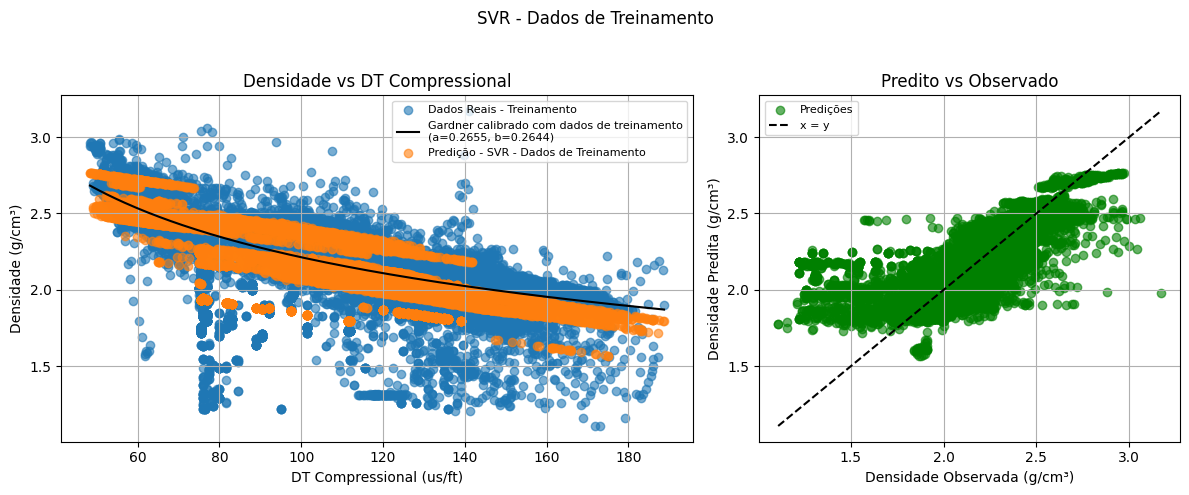

Métricas - SVR - Dados de Treinamento
R²: 0.7376
MSE: 0.0141
SSE: 813.7270


/tmp/ipython-input-42-26961262.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_train, met_svm_train = avaliar_modelo_regressao(y_predict, df_train, titulo= 'SVR - Dados de Treinamento', nome_modelo = "SVR", tipo_dado = "Treinamento")

## **Teste 1**

In [ ]:
y_predict2n = pd.DataFrame(ModeloSVM.predict(test1_entn))
y_predict2n

0
0      0.423444
1      0.431260
2      0.438778
3      0.452095
4      0.454486
...         ...
13369  0.680088
13370  0.696518
13371  0.696149
13372  0.695930
13373  0.695840

[13374 rows x 1 columns]

In [ ]:
#Desnormalização dados de teste 1
y_predict2 = scaler2.inverse_transform(y_predict2n) #Usando o valores máximos e mínimos definidos pelos vetores reais.
y_predict2 = np.ravel(y_predict2)
print(pd.DataFrame(y_predict2))

              0
0      1.982294
1      1.998396
2      2.013883
3      2.041316
4      2.046241
...         ...
13369  2.510982
13370  2.544827
13371  2.544067
13372  2.543615
13373  2.543431

[13374 rows x 1 columns]


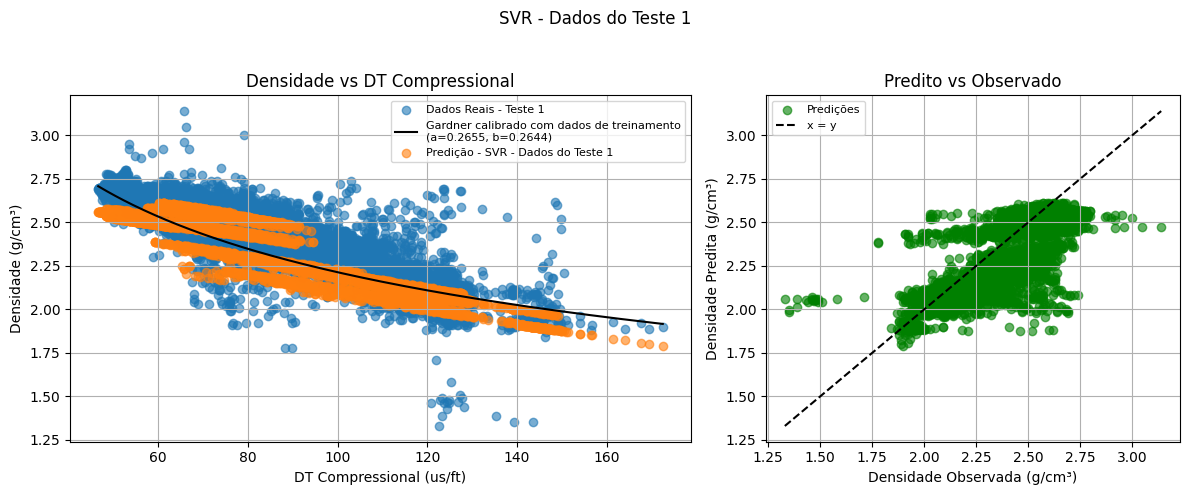

Métricas - SVR - Dados do Teste 1
R²: 0.6725
MSE: 0.0167
SSE: 223.4564


/tmp/ipython-input-42-26961262.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_test1, met_svm_test1 = avaliar_modelo_regressao(y_predict2, df_test1, titulo= 'SVR - Dados do Teste 1', nome_modelo = "SVR", tipo_dado = "Teste 1")

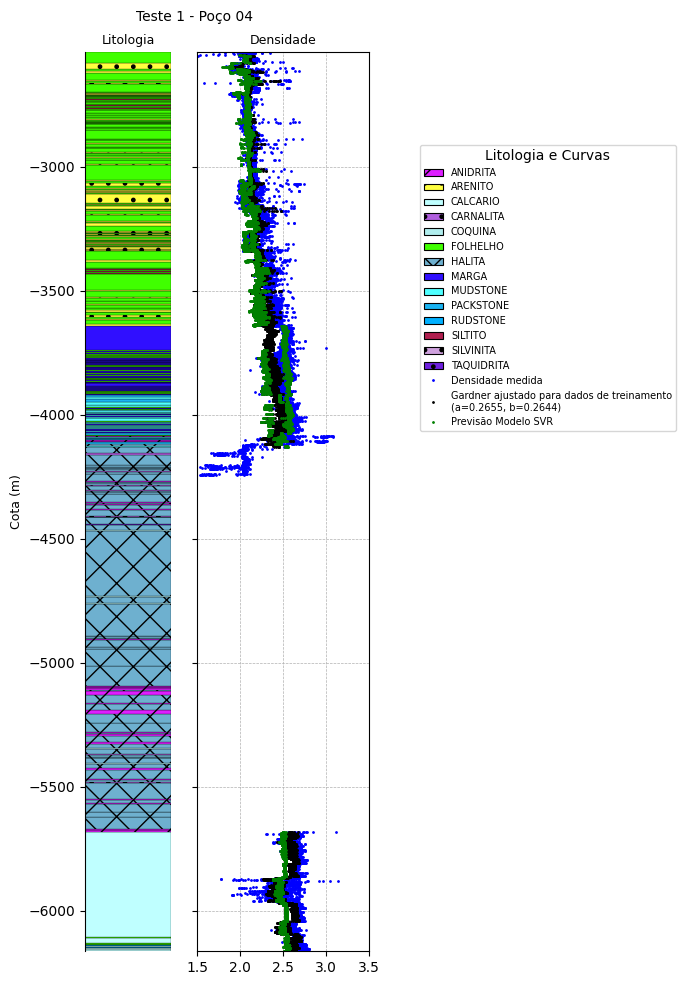

In [ ]:
dados_test1_SVM = {
    'DENSIDADE': y_predict2,
    'Cota': df_test1["Cota"],
    'DT COMPRESSIONAL': df_test1["DT COMPRESSIONAL"],
    'titulo_grafico': 'Teste 1 - Poço 04',
    'legenda_modelo': 'SVR'
}

pocotest1 = df_test1['Poço'].iloc[0]

plotar_litologia_e_densidade_Modelo(
    dataset_original[dataset_original['Poço'] == pocotest1],
    dados_test1_SVM
)

## **Teste 2**

In [ ]:
y_final2predictn = pd.DataFrame(ModeloSVM.predict(test2_entn))
y_final2predictn

0
0     0.464181
1     0.463514
2     0.461411
3     0.460651
4     0.463135
...        ...
9802  0.670187
9803  0.670228
9804  0.670251
9805  0.670255
9806  0.670278

[9807 rows x 1 columns]

In [ ]:
#Desnormalização dados de teste 2
y_final2predict = scaler2.inverse_transform(y_final2predictn) #Usando o valores máximos e mínimos definidos pelos vetores reais.
y_final2predict = np.ravel(y_final2predict)
print(pd.DataFrame(y_final2predict))

             0
0     2.066213
1     2.064839
2     2.060507
3     2.058940
4     2.064057
...        ...
9802  2.490585
9803  2.490670
9804  2.490717
9805  2.490725
9806  2.490772

[9807 rows x 1 columns]


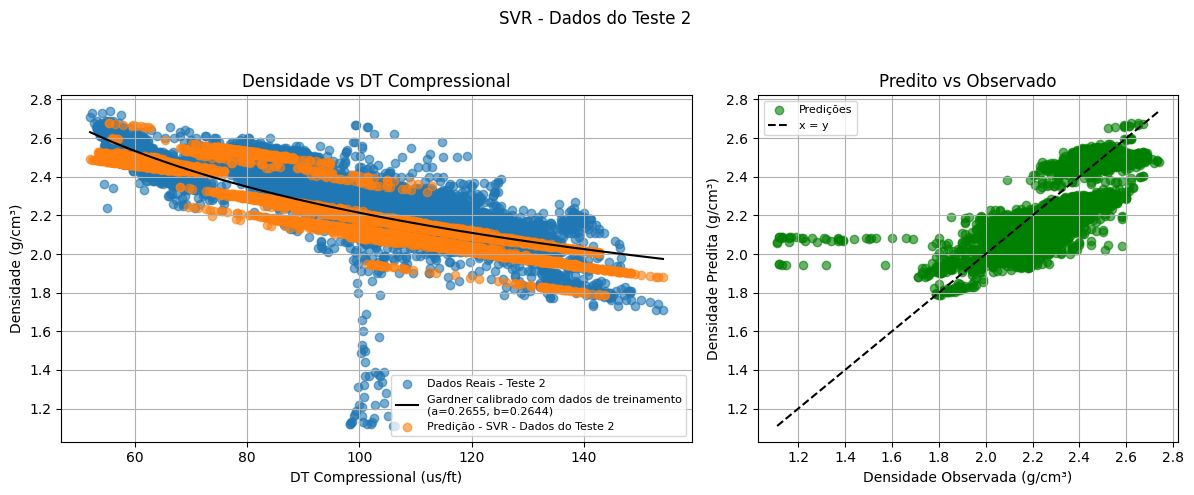

Métricas - SVR - Dados do Teste 2
R²: 0.5740
MSE: 0.0159
SSE: 155.8184


/tmp/ipython-input-42-26961262.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_test2, met_svm_test2 = avaliar_modelo_regressao(y_final2predict, df_test2, titulo= 'SVR - Dados do Teste 2', nome_modelo = "SVR", tipo_dado = "Teste 2")

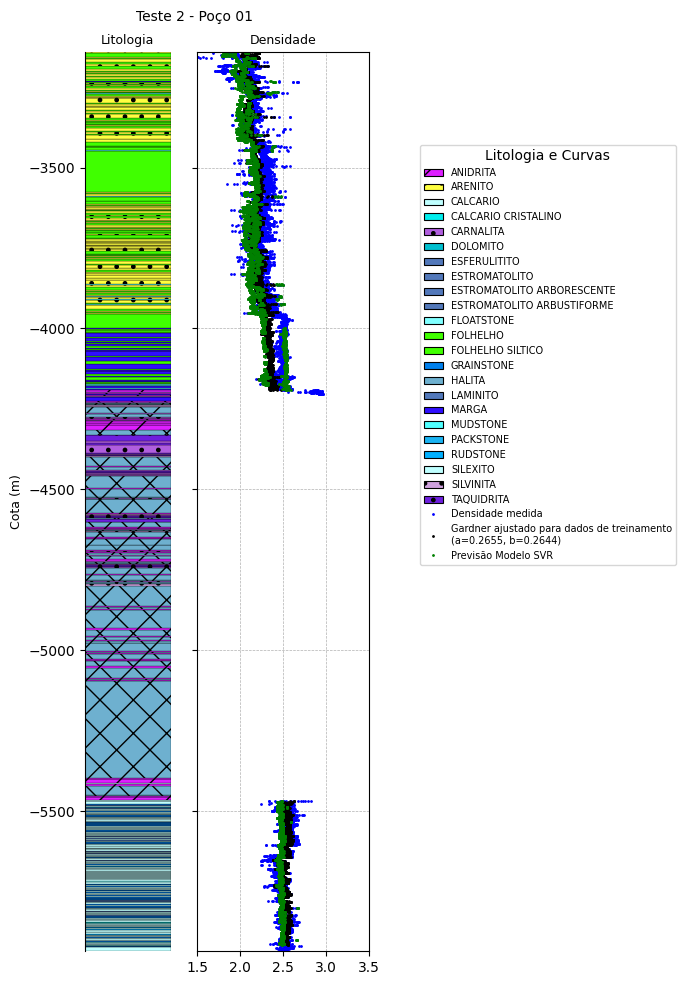

In [ ]:
dados_test2_SVM = {
    'DENSIDADE': y_final2predict,
    'Cota': df_test2["Cota"],
    'DT COMPRESSIONAL': df_test2["DT COMPRESSIONAL"],
    'titulo_grafico': 'Teste 2 - Poço 01',
    'legenda_modelo': 'SVR'
}

pocotest2 = df_test2['Poço'].iloc[0]

plotar_litologia_e_densidade_Modelo(
    dataset_original[dataset_original['Poço'] == pocotest2],
    dados_test2_SVM
)

# **Árvore de Decisão**

## **Seleção de Topologia**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
ModeloAD = tree.DecisionTreeRegressor() #o parâmetro max_iter não é válido para o DecisionTreeRegressor do sklearn.tree

In [ ]:
parametrosAD = [{'criterion':["squared_error", "friedman_mse","absolute_error"],
               'max_depth':[3,5, None],
               'min_samples_split':[2,4],
               'min_samples_leaf':[1,3,5]}]

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator = ModeloAD,
                    param_grid = parametrosAD,
                    cv=5,
                    verbose=2)
grid.fit(train_entn, train_sain)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.1s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=4; total time=   0.1s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=4; total time=   0.1s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=4; total time=   0.1s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_spl

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'criterion': ['squared_error', 'friedman_mse',
                                        'absolute_error'],
                          'max_depth': [3, 5, None],
                          'min_samples_leaf': [1, 3, 5],
                          'min_samples_split': [2, 4]}],
             verbose=2)

In [ ]:
resultados = pd.DataFrame(grid.cv_results_)[['params','rank_test_score','mean_test_score']]
resultados = resultados.sort_values(by='rank_test_score')
resultados

params  rank_test_score  \
46  {'criterion': 'absolute_error', 'max_depth': 5...                1   
47  {'criterion': 'absolute_error', 'max_depth': 5...                2   
42  {'criterion': 'absolute_error', 'max_depth': 5...                3   
43  {'criterion': 'absolute_error', 'max_depth': 5...                4   
44  {'criterion': 'absolute_error', 'max_depth': 5...                5   
45  {'criterion': 'absolute_error', 'max_depth': 5...                6   
24  {'criterion': 'friedman_mse', 'max_depth': 5, ...                7   
6   {'criterion': 'squared_error', 'max_depth': 5,...                8   
29  {'criterion': 'friedman_mse', 'max_depth': 5, ...                9   
28  {'criterion': 'friedman_mse', 'max_depth': 5, ...               10   
11  {'criterion': 'squared_error', 'max_depth': 5,...               11   
10  {'criterion': 'squared_error', 'max_depth': 5,...               12   
25  {'criterion': 'friedman_mse', 'max_depth': 5, ...               13   
7   {'criterion': 'squared_error', 'max_depth': 5,...               14   
27  {'criterion': 'friedman_mse', 'max_depth': 5, ...               15   
8   {'criterion': 'squared_error', 'max_depth': 5,...               16   
26  {'criterion': 'friedman_mse', 'max_depth': 5, ...               17   
9   {'criterion': 'squared_error', 'max_depth': 5,...               18   
38  {'criterion': 'absolute_error', 'max_depth': 3...               19   
39  {'criterion': 'absolute_error', 'max_depth': 3...               19   
41  {'criterion': 'absolute_error', 'max_depth': 3...               19   
40  {'criterion': 'absolute_error', 'max_depth': 3...               19   
37  {'criterion': 'absolute_error', 'max_depth': 3...               19   
36  {'criterion': 'absolute_error', 'max_depth': 3...               19   
22  {'criterion': 'friedman_mse', 'max_depth': 3, ...               25   
4   {'criterion': 'squared_error', 'max_depth': 3,...               26   
23  {'criterion': 'friedman_mse', 'max_depth': 3, ...               27   
1   {'criterion': 'squared_error', 'max_depth': 3,...               28   
5   {'criterion': 'squared_error', 'max_depth': 3,...               29   
2   {'criterion': 'squared_error', 'max_depth': 3,...               30   
18  {'criterion': 'friedman_mse', 'max_depth': 3, ...               31   
3   {'criterion': 'squared_error', 'max_depth': 3,...               32   
19  {'criterion': 'friedman_mse', 'max_depth': 3, ...               33   
0   {'criterion': 'squared_error', 'max_depth': 3,...               34   
20  {'criterion': 'friedman_mse', 'max_depth': 3, ...               35   
21  {'criterion': 'friedman_mse', 'max_depth': 3, ...               36   
34  {'criterion': 'friedman_mse', 'max_depth': Non...               37   
35  {'criterion': 'friedman_mse', 'max_depth': Non...               38   
17  {'criterion': 'squared_error', 'max_depth': No...               39   
16  {'criterion': 'squared_error', 'max_depth': No...               40   
15  {'criterion': 'squared_error', 'max_depth': No...               41   
32  {'criterion': 'friedman_mse', 'max_depth': Non...               42   
33  {'criterion': 'friedman_mse', 'max_depth': Non...               43   
14  {'criterion': 'squared_error', 'max_depth': No...               44   
13  {'criterion': 'squared_error', 'max_depth': No...               45   
49  {'criterion': 'absolute_error', 'max_depth': N...               46   
31  {'criterion': 'friedman_mse', 'max_depth': Non...               47   
12  {'criterion': 'squared_error', 'max_depth': No...               48   
48  {'criterion': 'absolute_error', 'max_depth': N...               49   
30  {'criterion': 'friedman_mse', 'max_depth': Non...               50   
50  {'criterion': 'absolute_error', 'max_depth': N...               51   
51  {'criterion': 'absolute_error', 'max_depth': N...               52   
52  {'criterion': 'absolute_error', 'max_depth': N...               53   
53  {'criterion': 'absolute_error', 'max_depth': N.

In [ ]:
print("Melhores parâmetros:", grid.best_params_)

Melhores parâmetros: {'criterion': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}


## **Treinamento**

Atenção!!!

Foram feitos testes com as combinações presentes nos top 10 do rank, para selecionar o melhor resultado combinado de R2, considerando o treinamento, teste 1 e teste 2, conforme segue:

### Desempenho das Árvores de Decisão Avaliadas

| Criterion         | Max Depth | Min Samples Leaf | Min Samples Split | Conjunto     | R²       | MSE       | SSE       |
|-------------------|-----------|-------------------|-------------------|--------------|---------|----------|---------|
| ⭐ absolute_error  | 5         | 5                 | 2                 | Treinamento  | 0.7922  | 0.0112   | 644.28  |
|                   |           |                   |                   | Teste 1      | 0.6683  | 0.0169   | 226.33  |
|                   |           |                   |                   | Teste 2      | 0.5652  | 0.0162   | 159.06  |
| absolute_error    | 5         | 5                 | 4                 | Treinamento  | 0.7922  | 0.0112   | 644.28  |
|                   |           |                   |                   | Teste 1      | 0.6683  | 0.0169   | 226.33  |
|                   |           |                   |                   | Teste 2      | 0.5652  | 0.0162   | 159.05  |
| absolute_error    | 5         | 1                 | 2                 | Treinamento  | 0.7922  | 0.0112   | 644.28  |
|                   |           |                   |                   | Teste 1      | 0.6683  | 0.0169   | 226.33  |
|                   |           |                   |                   | Teste 2      | 0.5652  | 0.0162   | 159.05  |
| absolute_error    | 5         | 1                 | 4                 | Treinamento  | 0.7922  | 0.0112   | 644.28  |
|                   |           |                   |                   | Teste 1      | 0.6683  | 0.0169   | 226.33  |
|                   |           |                   |                   | Teste 2      | 0.5652  | 0.0162   | 159.06  |
| absolute_error    | 5         | 3                 | 2                 | Treinamento  | 0.7922  | 0.0112   | 644.28  |
|                   |           |                   |                   | Teste 1      | 0.6683  | 0.0169   | 226.33  |
|                   |           |                   |                   | Teste 2      | 0.5652  | 0.0162   | 159.06  |
| absolute_error    | 5         | 3                 | 4                 | Treinamento  | 0.7922  | 0.0112   | 644.28  |
|                   |           |                   |                   | Teste 1      | 0.6683  | 0.0169   | 226.33  |
|                   |           |                   |                   | Teste 2      | 0.5652  | 0.0162   | 159.05  |
| friedman_mse      | 5         | 1                 | 2                 | Treinamento  | 0.7966  | 0.0109   | 630.74  |
|                   |           |                   |                   | Teste 1      | 0.6141  | 0.0197   | 263.30  |
|                   |           |                   |                   | Teste 2      | 0.4621  | 0.0201   | 196.76  |
| squared_error     | 5         | 1                 | 2                 | Treinamento  | 0.7966  | 0.0109   | 630.74  |
|                   |           |                   |                   | Teste 1      | 0.6141  | 0.0197   | 263.30  |
|                   |           |                   |                   | Teste 2      | 0.4621  | 0.0201   | 196.76  |
| friedman_mse      | 5         | 5                 | 4                 | Treinamento  | 0.7966  | 0.0109   | 630.74  |
|                   |           |                   |                   | Teste 1      | 0.6141  | 0.0197   | 263.30  |
|                   |           |                   |                   | Teste 2      | 0.4621  | 0.0201   | 196.76  |
| friedman_mse      | 5         | 5                 | 2                 | Treinamento  | 0.7966  | 0.0109   | 630.74  |
|                   |           |                   |                   | Teste 1      | 0.6141  | 0.0197   | 263.30  |
|                   |           |                   |                   | Teste 2      | 0.4621  | 0.0201   | 196.76  |

---

⭐ **Modelo escolhido:**  
`criterion = absolute_error`, `max_depth = 5`, `min_samples_leaf = 5`, `min_samples_split = 2`

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

ModeloAD = DecisionTreeRegressor(criterion="absolute_error",
                              max_depth=5,
                              min_samples_split=2,
                              min_samples_leaf=5)

ModeloAD.fit(train_entn, train_sain)

DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      min_samples_leaf=5)

In [ ]:
from sklearn.tree import export_graphviz
from sklearn import tree

dot_data = tree.export_graphviz(ModeloAD, #feature_names=train_ent.columns
                                 filled=True)

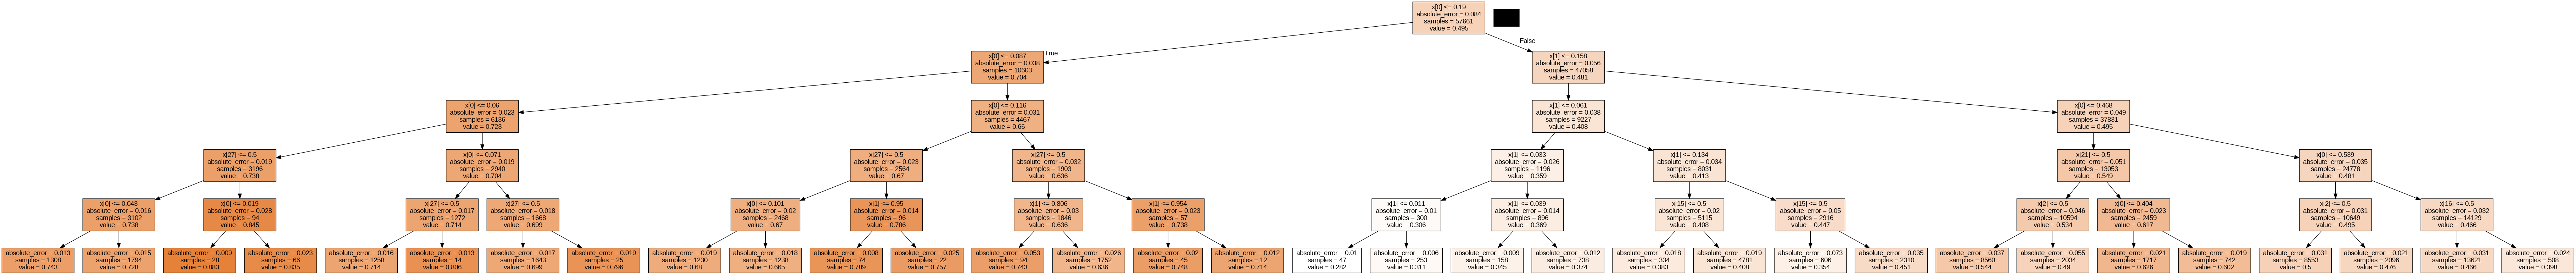

In [ ]:
import pydotplus
from IPython.display import Image
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
y_predictn = pd.DataFrame(ModeloAD.predict(train_entn))  #Uso dos dados de entrada normalizados para predição pelo modelo.

#y_predictn

In [ ]:
#Desnormalização dos dados
y_predict = scaler2.inverse_transform(y_predictn) #Usando o valores máximos e mínimos definidos pelos vetores reais.
y_predict = np.ravel(y_predict)
print(pd.DataFrame(y_predict))

          0
0      2.14
1      2.14
2      2.14
3      2.14
4      2.14
...     ...
57656  2.55
57657  2.55
57658  2.55
57659  2.55
57660  2.55

[57661 rows x 1 columns]


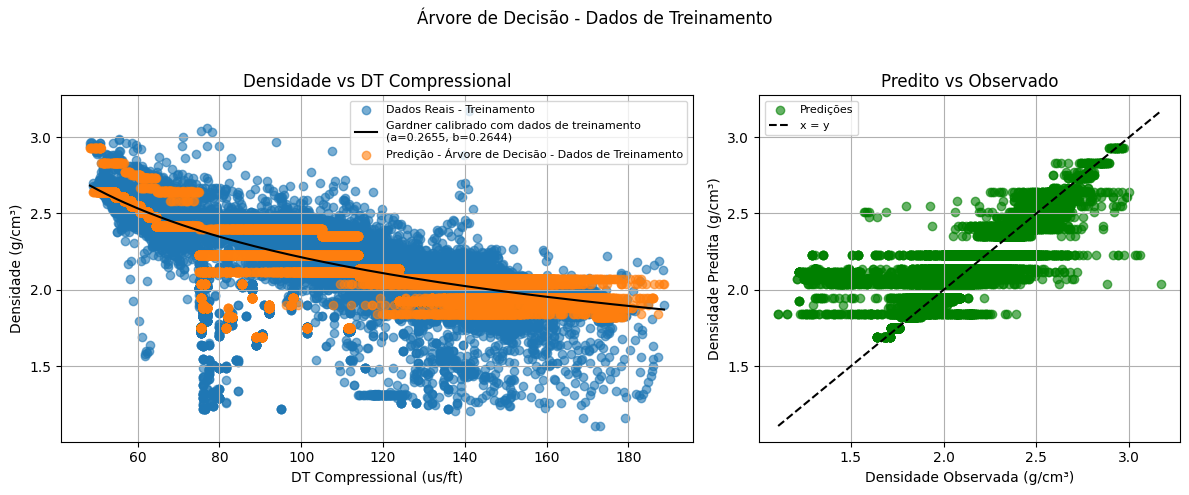

Métricas - Árvore de Decisão - Dados de Treinamento
R²: 0.7922
MSE: 0.0112
SSE: 644.2778


/tmp/ipython-input-42-26961262.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_train, met_ad_train = avaliar_modelo_regressao(y_predict, df_train, titulo= 'Árvore de Decisão - Dados de Treinamento', nome_modelo = "AD", tipo_dado = "Treinamento")

## **Teste 1**

In [ ]:
y_predict2n = pd.DataFrame(ModeloAD.predict(test1_entn))
y_predict2n

0
0      0.466019
1      0.466019
2      0.466019
3      0.466019
4      0.466019
...         ...
13369  0.713592
13370  0.713592
13371  0.713592
13372  0.713592
13373  0.699029

[13374 rows x 1 columns]

In [ ]:
#Desnormalização dados de teste 1
y_predict2 = scaler2.inverse_transform(y_predict2n) #Usando o valores máximos e mínimos definidos pelos vetores reais.
y_predict2 = np.ravel(y_predict2)
print(pd.DataFrame(y_predict2))

          0
0      2.07
1      2.07
2      2.07
3      2.07
4      2.07
...     ...
13369  2.58
13370  2.58
13371  2.58
13372  2.58
13373  2.55

[13374 rows x 1 columns]


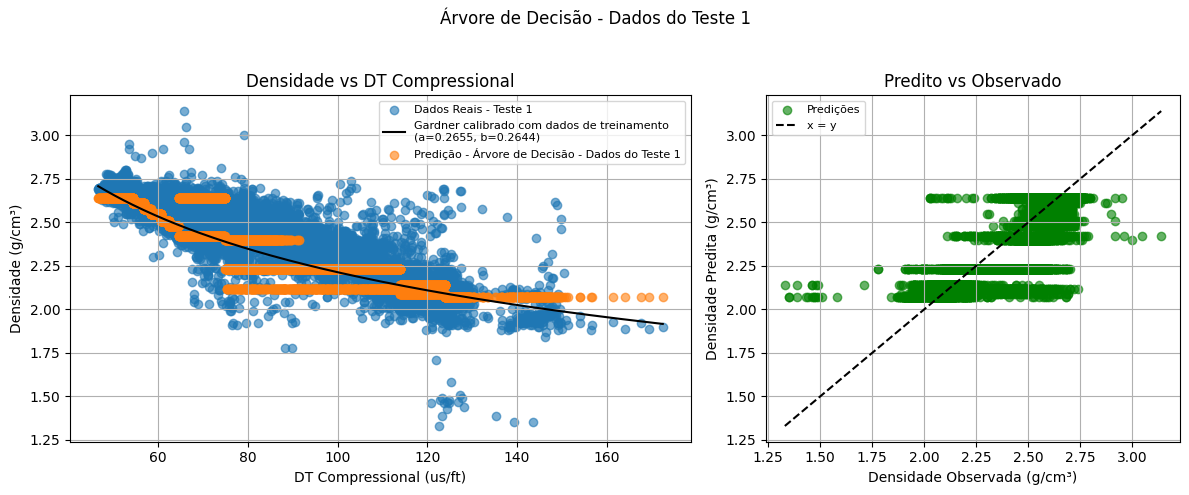

Métricas - Árvore de Decisão - Dados do Teste 1
R²: 0.6683
MSE: 0.0169
SSE: 226.3281


/tmp/ipython-input-42-26961262.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_test1, met_ad_test1 = avaliar_modelo_regressao(y_predict2, df_test1, titulo= 'Árvore de Decisão - Dados do Teste 1', nome_modelo = "AD", tipo_dado = "Teste 1")

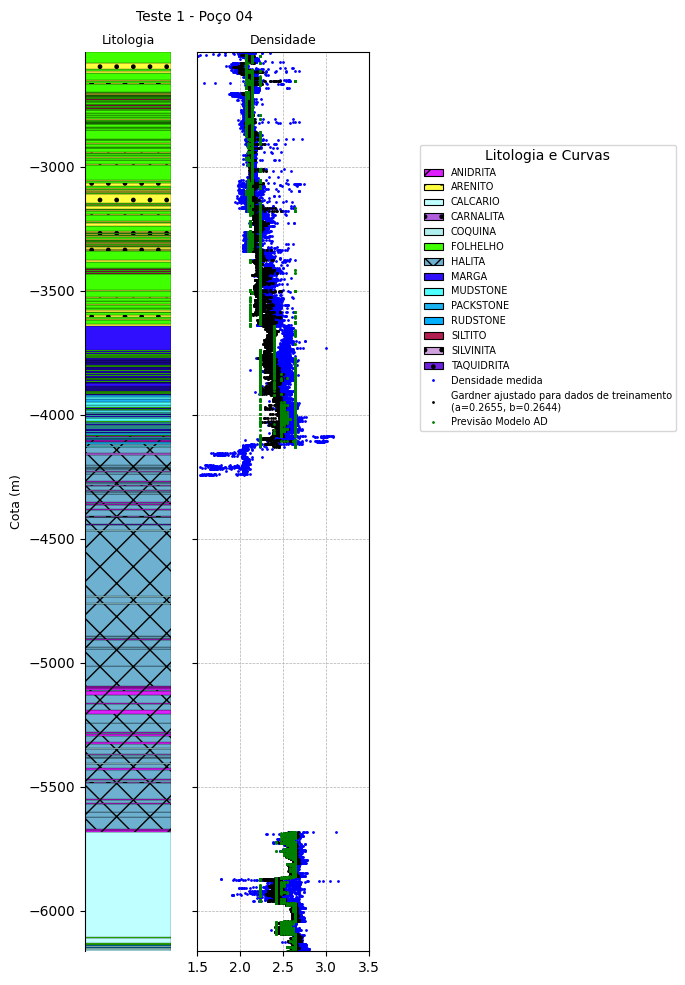

In [ ]:
dados_test1_AD = {
    'DENSIDADE': y_predict2,
    'Cota': df_test1["Cota"],
    'DT COMPRESSIONAL': df_test1["DT COMPRESSIONAL"],
    'titulo_grafico': 'Teste 1 - Poço 04',
    'legenda_modelo': 'AD'
}

pocotest1 = df_test1['Poço'].iloc[0]

plotar_litologia_e_densidade_Modelo(
    dataset_original[dataset_original['Poço'] == pocotest1],
    dados_test1_AD
)

## **Teste 2**

In [ ]:
y_final2predictn = pd.DataFrame(ModeloAD.predict(test2_entn))
y_final2predictn

0
0     0.490291
1     0.490291
2     0.490291
3     0.490291
4     0.490291
...        ...
9802  0.713592
9803  0.713592
9804  0.713592
9805  0.713592
9806  0.713592

[9807 rows x 1 columns]

In [ ]:
#Desnormalização dados de teste 2
y_final2predict = scaler2.inverse_transform(y_final2predictn) #Usando o valores máximos e mínimos definidos pelos vetores reais.
y_final2predict = np.ravel(y_final2predict)
print(pd.DataFrame(y_final2predict))

         0
0     2.12
1     2.12
2     2.12
3     2.12
4     2.12
...    ...
9802  2.58
9803  2.58
9804  2.58
9805  2.58
9806  2.58

[9807 rows x 1 columns]


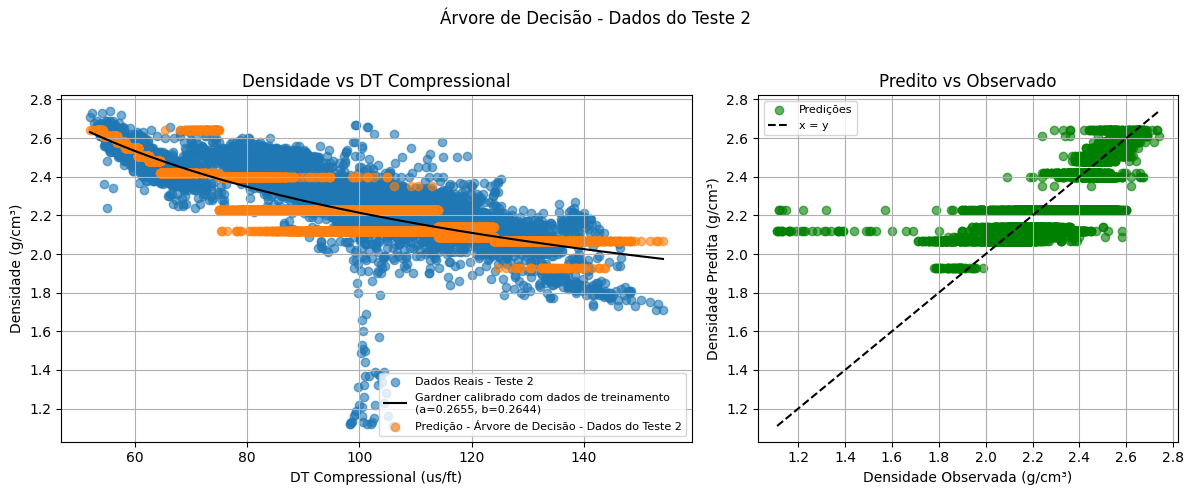

Métricas - Árvore de Decisão - Dados do Teste 2
R²: 0.5652
MSE: 0.0162
SSE: 159.0560


/tmp/ipython-input-42-26961262.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_test2, met_ad_test2 = avaliar_modelo_regressao(y_final2predict, df_test2, titulo= 'Árvore de Decisão - Dados do Teste 2', nome_modelo = "AD", tipo_dado = "Teste 2")

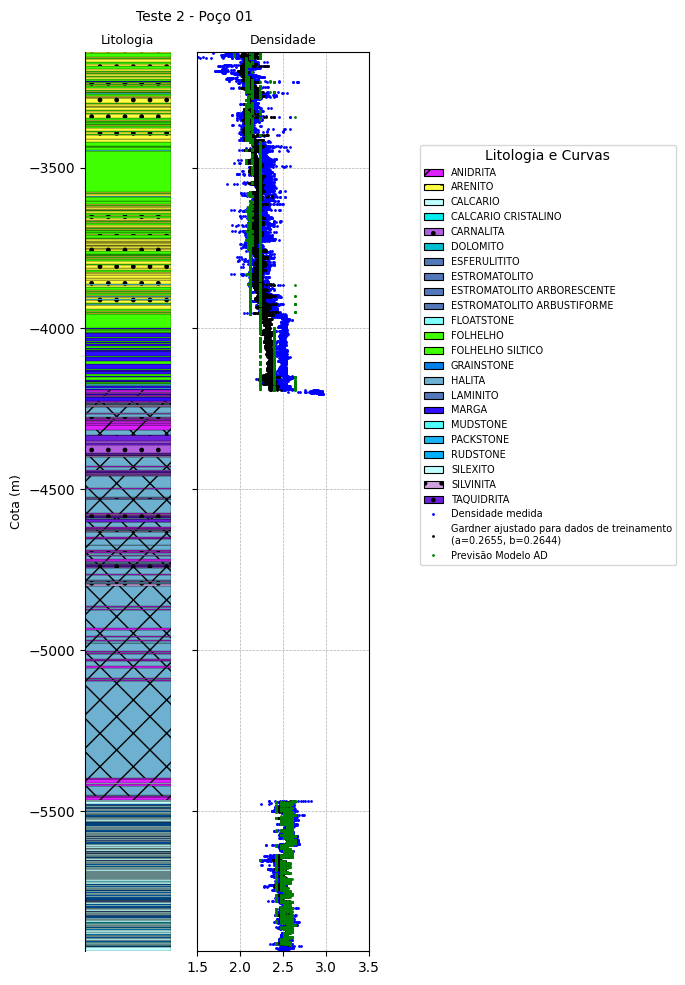

In [ ]:
dados_test2_AD = {
    'DENSIDADE': y_final2predict,
    'Cota': df_test2["Cota"],
    'DT COMPRESSIONAL': df_test2["DT COMPRESSIONAL"],
    'titulo_grafico': 'Teste 2 - Poço 01',
    'legenda_modelo': 'AD'
}

pocotest2 = df_test2['Poço'].iloc[0]

plotar_litologia_e_densidade_Modelo(
    dataset_original[dataset_original['Poço'] == pocotest2],
    dados_test2_AD
)

# **Redes Neurais Artificiais**

##**Seleção de Topologia**

In [ ]:
from sklearn.neural_network import MLPRegressor

ModeloRNA = MLPRegressor() #cria um objeto

In [ ]:
parametrosRNA = [{'hidden_layer_sizes':[(6,), (9,), (12,), (50,), (100,), (6, 6), (30,20), (50, 25), (30, 20, 10)],
               'activation':["logistic","tanh", "relu"],
               'solver':["lbfgs","sgd","adam"],
               'learning_rate':["constant","adaptive"]}]

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator = ModeloRNA,
                    param_grid = parametrosRNA,
                    scoring = 'r2',
                    cv =5,
                    verbose=2)
grid.fit(train_entn, train_sain)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END activation=logistic, hidden_layer_sizes=(6,), learning_rate=constant, solver=lbfgs; total time=   1.3s
[CV] END activation=logistic, hidden_layer_sizes=(6,), learning_rate=constant, solver=lbfgs; total time=   1.2s
[CV] END activation=logistic, hidden_layer_sizes=(6,), learning_rate=constant, solver=lbfgs; total time=   1.2s
[CV] END activation=logistic, hidden_layer_sizes=(6,), learning_rate=constant, solver=lbfgs; total time=   1.8s
[CV] END activation=logistic, hidden_layer_sizes=(6,), learning_rate=constant, solver=lbfgs; total time=   0.8s
[CV] END activation=logistic, hidden_layer_sizes=(6,), learning_rate=constant, solver=sgd; total time=   1.3s
[CV] END activation=logistic, hidden_layer_sizes=(6,), learning_rate=constant, solver=sgd; total time=   3.2s
[CV] END activation=logistic, hidden_layer_sizes=(6,), learning_rate=constant, solver=sgd; total time=   1.5s
[CV] END activation=logistic, hidden_layer_size

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptive, solver=lbfgs; total time=  45.6s
[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptive, solver=lbfgs; total time=   6.1s
[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptive, solver=lbfgs; total time=  11.7s
[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptive, solver=lbfgs; total time=  10.1s
[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptive, solver=sgd; total time=  14.5s
[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptive, solver=sgd; total time=  14.9s
[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptive, solver=sgd; total time=  14.7s
[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptive, solver=sgd; total time=  13.6s
[CV] END activation=relu, hidden_layer_sizes=(30, 20, 10), learning_rate=adaptiv

GridSearchCV(cv=5, estimator=MLPRegressor(),
             param_grid=[{'activation': ['logistic', 'tanh', 'relu'],
                          'hidden_layer_sizes': [(6,), (9,), (12,), (50,),
                                                 (100,), (6, 6), (30, 20),
                                                 (50, 25), (30, 20, 10)],
                          'learning_rate': ['constant', 'adaptive'],
                          'solver': ['lbfgs', 'sgd', 'adam']}],
             scoring='r2', verbose=2)

In [ ]:
pd.DataFrame(grid.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         1.252981      0.323763         0.009620        0.003107   
1         1.861485      0.687739         0.006599        0.004242   
2         1.182038      0.118816         0.004536        0.000115   
3         1.916980      0.430323         0.013718        0.001150   
4         5.662997      1.193532         0.005885        0.002938   
..             ...           ...              ...             ...   
157       4.464109      0.845950         0.024494        0.020132   
158       4.138193      1.022510         0.018185        0.009208   
159      15.758065     15.126420         0.011857        0.001643   
160      14.333924      0.459965         0.037126        0.020867   
161       3.061604      0.457225         0.031656        0.022944   

    param_activation param_hidden_layer_sizes param_learning_rate  \
0           logistic                     (6,)            constant   
1           logistic                     (6,)            constant   
2           logistic                     (6,)            constant   
3           logistic                     (6,)            adaptive   
4           logistic                     (6,)            adaptive   
..               ...                      ...                 ...   
157             relu             (30, 20, 10)            constant   
158             relu             (30, 20, 10)            constant   
159             relu             (30, 20, 10)            adaptive   
160             relu             (30, 20, 10)            adaptive   
161             relu             (30, 20, 10)            adaptive   

    param_solver                                             params  \
0          lbfgs  {'activation': 'logistic', 'hidden_layer_sizes...   
1            sgd  {'activation': 'logistic', 'hidden_layer_sizes...   
2           adam  {'activation': 'logistic', 'hidden_layer_sizes...   
3          lbfgs  {'activation': 'logistic', 'hidden_layer_sizes...   
4            sgd  {'activation': 'logistic', 'hidden_layer_sizes...   
..           ...                                                ...   
157          sgd  {'activation': 'relu', 'hidden_layer_sizes': (...   
158         adam  {'activation': 'relu', 'hidden_layer_sizes': (...   
159        lbfgs  {'activation': 'relu', 'hidden_layer_sizes': (...   
160          sgd  {'activation': 'relu', 'hidden_layer_sizes': (...   
161         adam  {'activation': 'relu', 'hidden_layer_sizes': (...   

     split0_test_score  split1_test_score  split2_test_score  \
0             0.844877           0.484220           0.780958   
1             0.298311          -0.829042           0.202869   
2             0.851637           0.340363           0.731693   
3             0.851173           0.296403           0.781139   
4             0.230379           0.040966           0.319625   
..                 ...                ...                ...   
157           0.764403          -0.056284          -0.184353   
158           0.843077           0.485991           0.790784   
159           0.812405          -2.375118           0.778486   
160           0.740579          -0.816503           0.701941   
161           0.841146          -0.625384           0.797757   

     split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0             0.453278           0.636006         0.639868        0.155558   
1            -0.158102           0.050769        -0.087039        0.401784   
2             0.491961           0.635116         0.610154        0.179145   
3             0.452748           0.643342         0.604961        0.205674   
4             0.113681          -0.146707         0.111589        0.160685   
..                 ...                ...              ...             ...   
157           0.613344           0.583093         0.344041        0.386221   
158           0.500843           0.654394         0.655018        0.145698   
159           0.508629 

In [ ]:
resultados = pd.DataFrame(grid.cv_results_)[['params','rank_test_score','mean_test_score']]
resultados = resultados.sort_values(by='rank_test_score')
resultados

params  rank_test_score  \
26   {'activation': 'logistic', 'hidden_layer_sizes...                1   
5    {'activation': 'logistic', 'hidden_layer_sizes...                2   
11   {'activation': 'logistic', 'hidden_layer_sizes...                3   
30   {'activation': 'logistic', 'hidden_layer_sizes...                4   
141  {'activation': 'relu', 'hidden_layer_sizes': (...                5   
..                                                 ...              ...   
110  {'activation': 'relu', 'hidden_layer_sizes': (...              158   
94   {'activation': 'tanh', 'hidden_layer_sizes': (...              159   
76   {'activation': 'tanh', 'hidden_layer_sizes': (...              160   
61   {'activation': 'tanh', 'hidden_layer_sizes': (...              161   
56   {'activation': 'tanh', 'hidden_layer_sizes': (...              162   

     mean_test_score  
26          0.671202  
5           0.665968  
11          0.663088  
30          0.661095  
141         0.660904  
..               ...  
110        -0.877161  
94         -0.978427  
76         -1.183220  
61         -1.520406  
56         -1.841459  

[162 rows x 3 columns]

In [ ]:
print("Melhores parâmetros:", grid.best_params_)

Melhores parâmetros: {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


## **Treinamento**

Atenção!!!

Apesar dos melhores parâmetros terem sido os listados acima, foram feitos testes com as combinações presentes nos top 10 do rank, para selecionar o melhor resultado combinado de R2, considerando o treinamento, teste 1 e teste 2. Seguem os resultados:



**Desempenho das Redes Neurais Avaliadas**

| Ativação   | Topologia           | Learning Rate | Solver  | Conjunto     | R²       | MSE      | SSE       |
|------------|---------------------|----------------|---------|--------------|----------|---------|----------|
|⭐ logistic   | (100,)             | constant       | adam    | Treinamento  | 0.7767   | 0.0120  | 692.47   |
|            |                     |                |         | Teste 1      | 0.8094   | 0.0097  | 130.06   |
|            |                     |                |         | Teste 2      | 0.7216   | 0.0104  | 101.84   |
|  logistic | (6,)               | adaptive       | adam    | Treinamento  | 0.7786   | 0.0119  | 686.40   |
|            |                     |                |         | Teste 1      | 0.7805   | 0.0112  | 149.72   |
|            |                     |                |         | Teste 2      | 0.6999   | 0.0112  | 109.77   |
| logistic   | (9,)               | adaptive       | adam    | Treinamento  | 0.7741   | 0.0121  | 700.36   |
|            |                     |                |         | Teste 1      | 0.7581   | 0.0123  | 165.07   |
|            |                     |                |         | Teste 2      | 0.6763   | 0.0121  | 118.43   |
| logistic   | (6, 6)             | constant       | lbfgs   | Treinamento  | 0.7715   | 0.0123  | 708.61   |
|            |                     |                |         | Teste 1      | 0.7801   | 0.0112  | 150.03   |
|            |                     |                |         | Teste 2      | 0.7188   | 0.0105  | 102.87   |
| relu       | (6, 6)             | adaptive       | lbfgs   | Treinamento  | 0.7745   | 0.0121  | 699.28   |
|            |                     |                |         | Teste 1      | 0.7609   | 0.0122  | 163.13   |
|            |                     |                |         | Teste 2      | 0.7326   | 0.0100  | 97.82    |
| tanh       | (6, 6)             | constant       | adam    | Treinamento  | 0.7794   | 0.0119  | 683.96   |
|            |                     |                |         | Teste 1      | 0.7859   | 0.0109  | 146.09   |
|            |                     |                |         | Teste 2      | 0.7218   | 0.0104  | 101.78   |
| logistic   | (6, 6)             | adaptive       | adam    | Treinamento  | 0.7759   | 0.0121  | 695.05   |
|            |                     |                |         | Teste 1      | 0.7531   | 0.0126  | 168.45   |
|            |                     |                |         | Teste 2      | 0.6977   | 0.0113  | 110.56   |
| relu       | (30, 20, 10)       | constant       | adam    | Treinamento  | 0.8328   | 0.0090  | 518.53   |
|            |                     |                |         | Teste 1      | 0.7110   | 0.0147  | 197.18   |
|            |                     |                |         | Teste 2      | 0.6405   | 0.0134  | 131.49   |
| logistic   | (30, 20)           | constant       | lbfgs   | Treinamento  | 0.7673   | 0.0125  | 721.45   |
|            |                     |                |         | Teste 1      | 0.7623   | 0.0121  | 162.20   |
|            |                     |                |         | Teste 2      | 0.7044   | 0.0110  | 108.13   |
| logistic   | (6, 6)             | adaptive       | lbfgs   | Treinamento  | 0.7743   | 0.0121  | 699.80   |
|            |                     |                |         | Teste 1      | 0.7765   | 0.0114  | 152.46   |
|            |                     |                |         | Teste 2      | 0.7164   | 0.0106  | 103.73   |

---

⭐ **Modelo escolhido:**  
`activation = logistic`, `hidden_layer_sizes = (100,)`, `learning_rate = constant`, `solver = adam`

Esse modelo foi selecionado por apresentar o melhor equilíbrio entre os conjuntos de treinamento e teste, com \(R²\) mais alto nos testes (especialmente no teste 1), baixa MSE e SSE, além de manter uma topologia simples e robusta.


In [ ]:
from sklearn.neural_network import MLPRegressor

#Especificar a topologia do modelo (fonte de investigação)

ModeloRNA = MLPRegressor(hidden_layer_sizes=(100,),
                      activation="logistic",
                      solver="adam",
                     learning_rate='constant')

ModeloRNA.fit(train_entn, train_sain) #ajuste do modelo pelos dados de entrada e comparando com os de saída

MLPRegressor(activation='logistic')

Text(0, 0.5, 'erro')

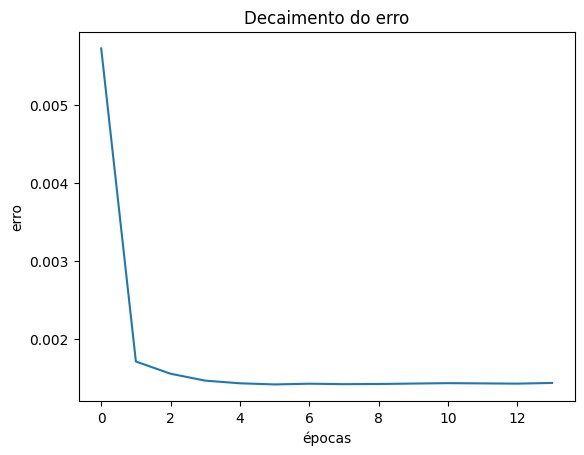

In [ ]:
#######Esta parte só funciona quando o solver é adam ou sgd

import matplotlib.pyplot as plt

plt.plot(ModeloRNA.loss_curve_)
plt.title('Decaimento do erro')
plt.xlabel('épocas')
plt.ylabel('erro')

In [ ]:
y_predictn = pd.DataFrame(ModeloRNA.predict(train_entn))  #Uso dos dados de entrada normalizados para predição pelo modelo.

#y_predictn

In [ ]:
#Desnormalização dos dados
y_predict = scaler2.inverse_transform(y_predictn) #Usando os valores máximos e mínimos definidos pelos vetores reais.
y_predict = np.ravel(y_predict)
print(pd.DataFrame(y_predict))

              0
0      2.144792
1      2.150004
2      2.150954
3      2.147260
4      2.140136
...         ...
57656  2.557908
57657  2.557473
57658  2.556899
57659  2.556603
57660  2.556410

[57661 rows x 1 columns]


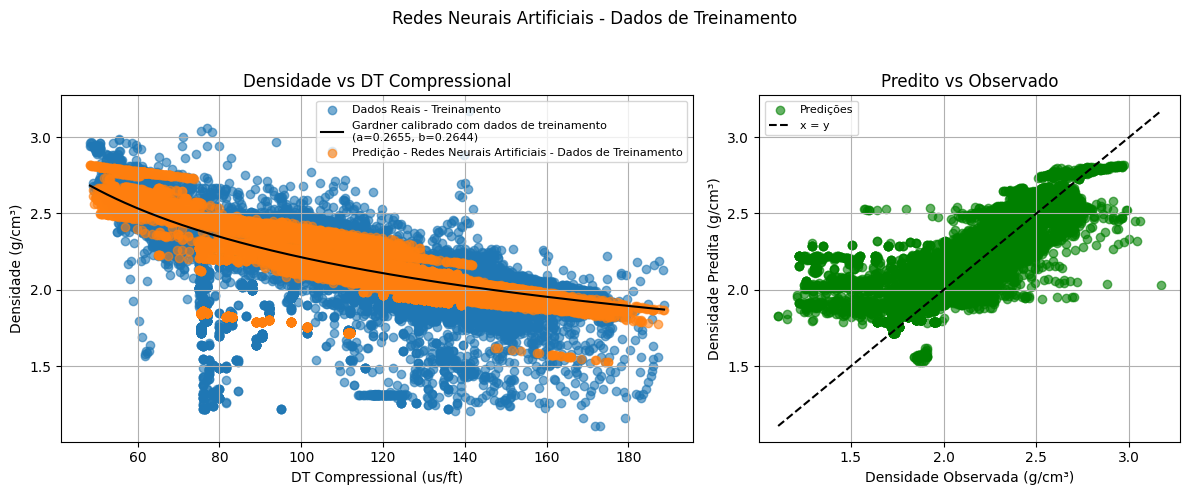

Métricas - Redes Neurais Artificiais - Dados de Treinamento
R²: 0.7767
MSE: 0.0120
SSE: 692.4729


/tmp/ipython-input-42-26961262.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_train, met_rna_train = avaliar_modelo_regressao(y_predict, df_train, titulo= 'Redes Neurais Artificiais - Dados de Treinamento', nome_modelo = "RNA", tipo_dado = "Treinamento")

In [ ]:
#Pesos
Pesos = ModeloRNA.coefs_

Pesos

[array([[-0.19744862,  0.0982045 ,  0.23388625, ...,  0.19258432,
          0.00590254, -0.08146823],
        [ 0.09424089, -0.16922721, -0.12045221, ..., -0.0935904 ,
         -0.07609601,  0.13791565],
        [-0.09909087, -0.0551797 , -0.00411867, ..., -0.01098443,
         -0.0988699 , -0.08011321],
        ...,
        [-0.05367295, -0.00524809,  0.07468179, ...,  0.02212937,
          0.00530746,  0.000914  ],
        [ 0.00688072,  0.00342473,  0.02225577, ..., -0.00033679,
         -0.12276819,  0.03321185],
        [-0.00218843, -0.00477702,  0.00871769, ..., -0.00181889,
         -0.02039119,  0.00176968]]),
 array([[ 0.03782733],
        [-0.02953919],
        [-0.11284843],
        [-0.11077615],
        [-0.0249213 ],
        [ 0.08096067],
        [ 0.07585347],
        [-0.03390245],
        [-0.03475973],
        [-0.1071634 ],
        [ 0.09762803],
        [-0.0891044 ],
        [ 0.11297691],
        [-0.07800734],
        [-0.11689683],
        [-0.01354123],
     

In [ ]:
#Bias
bias = ModeloRNA.intercepts_

bias

[array([-0.1117123 , -0.02613566, -0.08742313, -0.10396375, -0.00343882,
         0.00632251,  0.1208277 , -0.13490897, -0.02270953, -0.1168508 ,
        -0.01618981, -0.05861573,  0.00569534,  0.02039068, -0.09725534,
        -0.05751973,  0.02528327,  0.00970212,  0.08358734, -0.02790841,
        -0.01562368, -0.02043161,  0.0847143 , -0.07988881,  0.00532765,
        -0.10866412, -0.05338467,  0.10964837,  0.00628551, -0.02072937,
         0.0189912 , -0.01185067,  0.01025496,  0.04232503,  0.07110021,
         0.05381253,  0.0391388 , -0.06057266,  0.04810923,  0.03772621,
         0.11178083,  0.01991437, -0.09061039, -0.05317183, -0.05309311,
        -0.05624598, -0.00137905, -0.03563664,  0.08493118,  0.04028223,
        -0.11011144, -0.02677576,  0.0007307 , -0.07252666, -0.01312962,
         0.11650058,  0.00848635,  0.00992776,  0.07840026, -0.05432794,
        -0.0688933 , -0.13378614,  0.05368771, -0.06055891,  0.12520262,
         0.02718361,  0.00897947, -0.07218871,  0.0

## **Teste 1**

In [ ]:
y_predict2n = pd.DataFrame(ModeloRNA.predict(test1_entn))
y_predict2n

0
0      0.452111
1      0.459158
2      0.465937
3      0.477947
4      0.480106
...         ...
13369  0.757905
13370  0.731523
13371  0.731195
13372  0.731001
13373  0.730924

[13374 rows x 1 columns]

In [ ]:
#Desnormalização dados de teste 1
y_predict2 = scaler2.inverse_transform(y_predict2n) #Usando o valores máximos e mínimos definidos pelos vetores reais.
y_predict2 = np.ravel(y_predict2)
print(pd.DataFrame(y_predict2))

              0
0      2.041349
1      2.055865
2      2.069830
3      2.094571
4      2.099018
...         ...
13369  2.671284
13370  2.616938
13371  2.616262
13372  2.615863
13373  2.615704

[13374 rows x 1 columns]


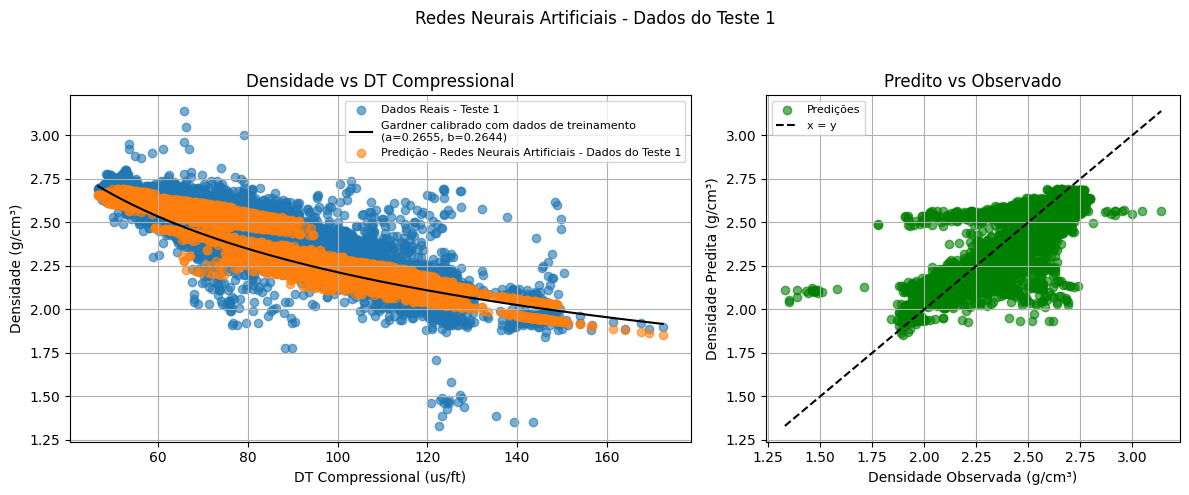

Métricas - Redes Neurais Artificiais - Dados do Teste 1
R²: 0.8094
MSE: 0.0097
SSE: 130.0645


/tmp/ipython-input-42-26961262.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_test1, met_rna_test1 = avaliar_modelo_regressao(y_predict2, df_test1, titulo= 'Redes Neurais Artificiais - Dados do Teste 1', nome_modelo = "RNA", tipo_dado = "Teste 1")

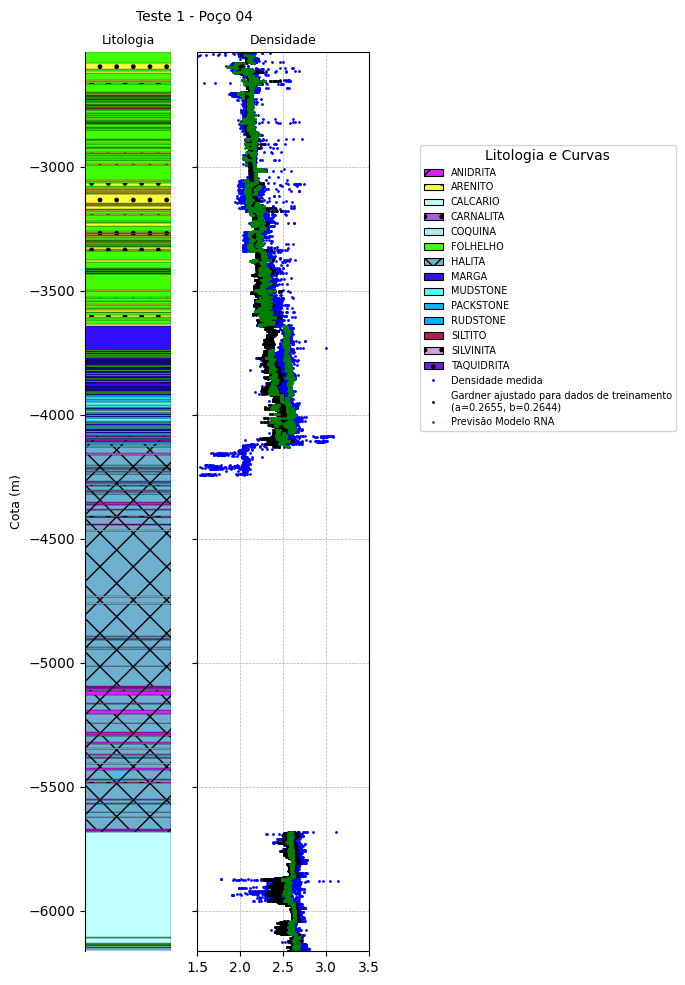

In [ ]:
dados_test1_RNA = {
    'DENSIDADE': y_predict2,
    'Cota': df_test1["Cota"],
    'DT COMPRESSIONAL': df_test1["DT COMPRESSIONAL"],
    'titulo_grafico': 'Teste 1 - Poço 04',
    'legenda_modelo': 'RNA'
}

pocotest1 = df_test1['Poço'].iloc[0]

plotar_litologia_e_densidade_Modelo(
    dataset_original[dataset_original['Poço'] == pocotest1],
    dados_test1_RNA
)

## **Teste 2**

In [ ]:
y_final1predictn = pd.DataFrame(ModeloRNA.predict(test2_entn)) #RNA teve maior R2 com dados de teste 1
y_final1predictn

0
0     0.486820
1     0.486221
2     0.484327
3     0.483644
4     0.485888
...        ...
9802  0.710342
9803  0.710382
9804  0.710406
9805  0.710412
9806  0.710436

[9807 rows x 1 columns]

In [ ]:
#Desnormalização dados de teste 1
y_final1predict = scaler2.inverse_transform(y_final1predictn) #Usando o valores máximos e mínimos definidos pelos vetores reais.
y_final1predict = np.ravel(y_final1predict)
print(pd.DataFrame(y_final1predict))

             0
0     2.112849
1     2.111616
2     2.107714
3     2.106307
4     2.110930
...        ...
9802  2.573305
9803  2.573388
9804  2.573436
9805  2.573450
9806  2.573498

[9807 rows x 1 columns]


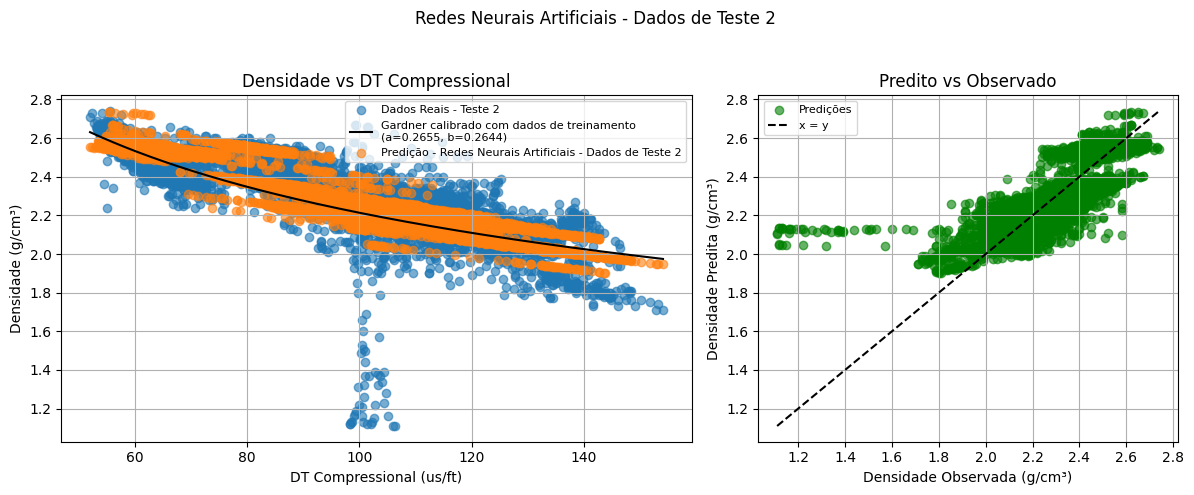

Métricas - Redes Neurais Artificiais - Dados de Teste 2
R²: 0.7216
MSE: 0.0104
SSE: 101.8441


/tmp/ipython-input-42-26961262.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo[nome_coluna_predita] = y_predito


In [ ]:
df_test2, met_rna_test2 = avaliar_modelo_regressao(y_final1predict, df_test2, titulo= 'Redes Neurais Artificiais - Dados de Teste 2', nome_modelo = "RNA", tipo_dado = "Teste 2")

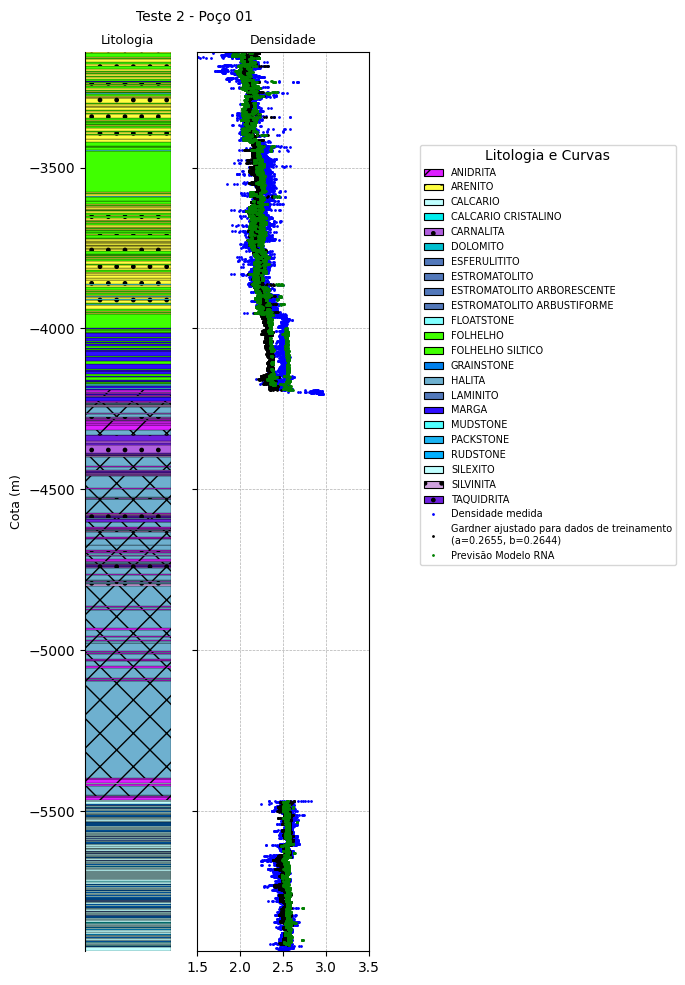

In [ ]:
dados_test2_RNA = {
    'DENSIDADE': y_final1predict,
    'Cota': df_test2["Cota"],
    'DT COMPRESSIONAL': df_test2["DT COMPRESSIONAL"],
    'titulo_grafico': 'Teste 2 - Poço 01',
    'legenda_modelo': 'RNA'
}

pocotest2 = df_test2['Poço'].iloc[0]

plotar_litologia_e_densidade_Modelo(
    dataset_original[dataset_original['Poço'] == pocotest2],
    dados_test2_RNA
)

# **Comparação Final entre Modelos**

In [ ]:
tabela_resultadosfinal = pd.concat([
    met_rna_train, met_rna_test1, met_rna_test2,
    met_ad_train, met_ad_test1, met_ad_test2,
    met_svm_train, met_svm_test1, met_svm_test2,
    met_gardner_train, met_gardner_test1, met_gardner_test
    ], ignore_index=True)
display(tabela_resultadosfinal)

Modelo Tipo de Dado        R²       MSE          SSE
0       RNA  Treinamento  0.776683  0.012009   692.472916
1       RNA      Teste 1  0.809371  0.009725   130.064461
2       RNA      Teste 2  0.721584  0.010385   101.844074
3        AD  Treinamento  0.792225  0.011174   644.277750
4        AD      Teste 1  0.668282  0.016923   226.328100
5        AD      Teste 2  0.565181  0.016219   159.056000
6       SVR  Treinamento  0.737579  0.014112   813.727000
7       SVR      Teste 1  0.672491  0.016708   223.456417
8       SVR      Teste 2  0.574032  0.015888   155.818449
9   Gardner  Treinamento  0.665463  0.017990  1037.350145
10  Gardner      Teste 1  0.725865  0.013985   187.040131
11  Gardner      Teste 2  0.630576  0.013779   135.134905

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plotar_litologia_e_comparacao_modelos(df_poco, dados_modelos):
    """
    Gera um gráfico com múltiplos tracks para comparar os modelos de densidade com os dados reais.
    """
    df_poco = df_poco.copy()
    df_poco['Cota'] = pd.to_numeric(df_poco['Cota'], errors='coerce')
    df_poco = df_poco.dropna(subset=['Cota'])

    intervalos = agrupar_intervalos(df_poco)
    nome_poco = df_poco['Poço'].iloc[0]

    n_tracks = len(dados_modelos) + 1

    width_ratios = [0.5] + [1] * (n_tracks - 1)

    fig, axes = plt.subplots(
        1, n_tracks, figsize=(2 * n_tracks + 4, 10),
        sharey=True,
        gridspec_kw={'width_ratios': width_ratios}
    )

    if n_tracks == 2:
        axes = [axes[0], axes[1]]

    ax_litologia = axes[0]
    litologias_presentes = set()

    for top, base, lit in intervalos:
        if base <= top:
            continue
        props = litologias_dict.get(lit, {"cor": "#FFFFFF", "hatch": ""})
        rect = patches.Rectangle(
            (0, top), 1, base - top,
            facecolor=props["cor"],
            edgecolor='black',
            hatch=props["hatch"],
            linewidth=0.2
        )
        ax_litologia.add_patch(rect)
        litologias_presentes.add(lit)

    ax_litologia.set_xlim(0, 1)
    ax_litologia.set_ylim(df_poco['Cota'].min(), df_poco['Cota'].max())
    ax_litologia.set_title('Litologia', fontsize=9)

    # Mostrar rótulo e valores no eixo Y
    ax_litologia.set_ylabel('Cota (m)', fontsize=9)
    ax_litologia.tick_params(axis='y', labelsize=8)
    ax_litologia.set_xticks([])
    ax_litologia.spines['top'].set_visible(False)
    ax_litologia.spines['right'].set_visible(False)
    ax_litologia.spines['bottom'].set_visible(False)

    # Para legenda final
    handles_curvas = []
    labels_curvas = []

    for i, dados_modelo in enumerate(dados_modelos):
        ax = axes[i + 1]
        densidade_modelo = dados_modelo['DENSIDADE']
        cota_modelo = dados_modelo['Cota']

        titulo_grafico = dados_modelo.get('titulo_grafico', 'Resultado da Regressão')
        legenda_modelo = dados_modelo.get('legenda_modelo', 'Modelo')

        p1 = ax.plot(df_poco['DENSIDADE'], df_poco['Cota'], color='blue', marker='.', linestyle='None',
                     markersize=2, label='Densidade medida')
        p2 = ax.plot(densidade_modelo, cota_modelo, color='green', marker='.', linestyle='None',
                     markersize=2, label='Modelo')

        ax.set_xlim(1.5, 3.5)
        ax.set_title(legenda_modelo, fontsize=9)
        ax.grid(True, linestyle='--', linewidth=0.5)

        if i == len(dados_modelos) - 1:
            ax.tick_params(axis='y', labelsize=0)  # Oculta os valores do eixo Y nos últimos axes

        # Salva handles apenas uma vez
        if i == 0:
            handles_curvas.extend([p1[0], p2[0]])
            labels_curvas.extend(['Densidade medida', 'Modelo'])

    # Legenda combinada (litologias + curvas)
    handles_lito = []
    for lit in sorted(litologias_presentes):
        props = litologias_dict.get(lit, {"cor": "#FFFFFF", "hatch": ""})
        patch = patches.Patch(
            facecolor=props["cor"],
            hatch=props["hatch"],
            edgecolor='black',
            label=lit,
            linewidth=0.8
        )
        handles_lito.append(patch)

    fig.legend(
        handles_lito + handles_curvas,
        [h.get_label() for h in handles_lito] + labels_curvas,
        loc='center left',
        bbox_to_anchor=(1.01, 0.5),
        fontsize=8,
        title='Litologias e Curvas'
    )

    fig.suptitle(f'Comparação entre modelos: {nome_poco}', fontsize=11)
    plt.tight_layout(rect=[0, 0, 0.99, 1])  # Deixa espaço para a legenda
    plt.show()



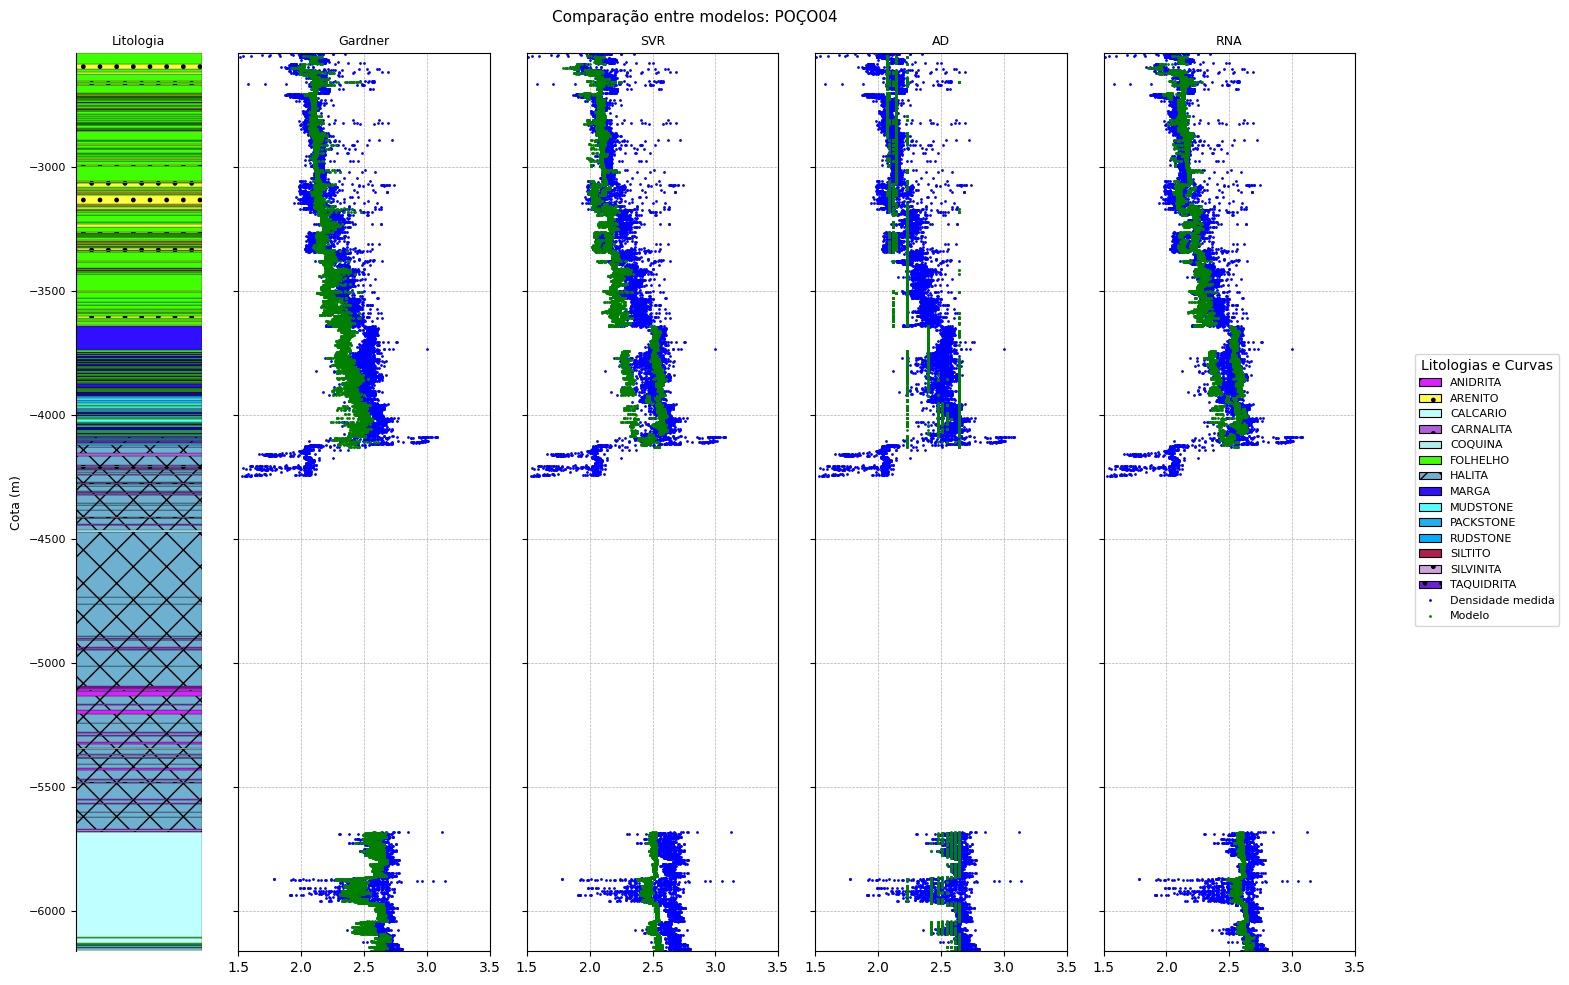

In [ ]:
dados_modelos_test1 = [
    dados_test1_Gardner,
    dados_test1_SVM,
    dados_test1_AD,
    dados_test1_RNA
]

pocotest1 = df_test1['Poço'].iloc[0]

plotar_litologia_e_comparacao_modelos(dataset_original[dataset_original['Poço'] == pocotest1], dados_modelos_test1)


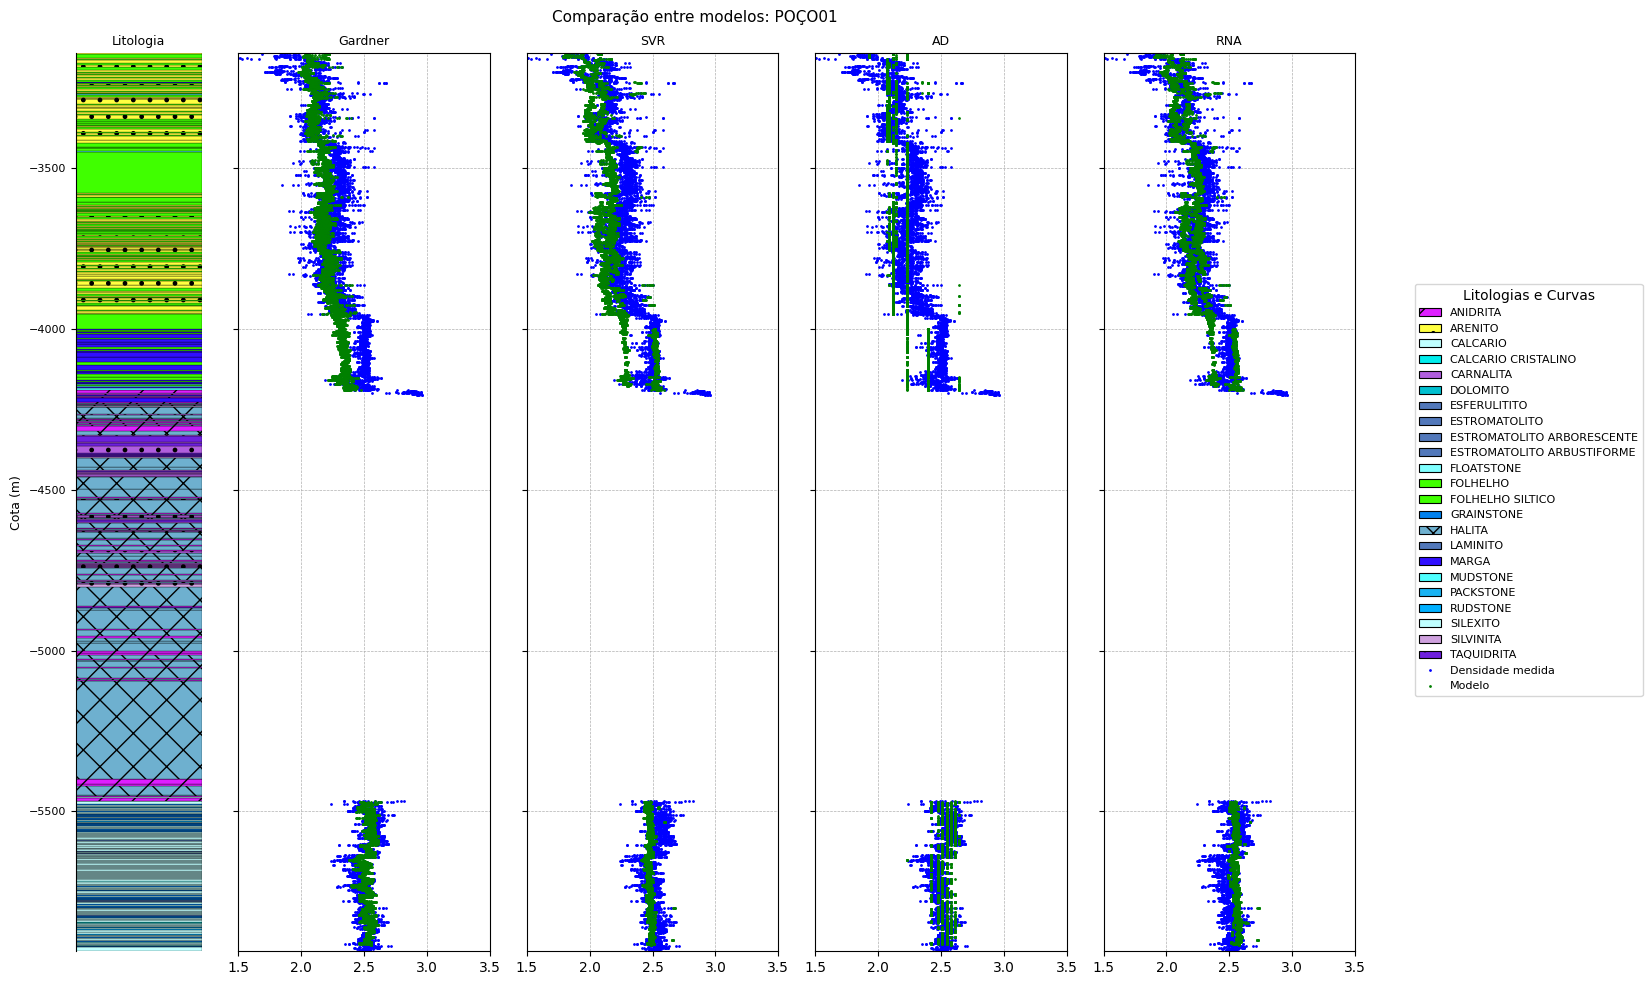

In [ ]:
dados_modelos_test2 = [
    dados_test2_Gardner,
    dados_test2_SVM,
    dados_test2_AD,
    dados_test2_RNA
]

pocotest2 = df_test2['Poço'].iloc[0]


plotar_litologia_e_comparacao_modelos(dataset_original[dataset_original['Poço'] == pocotest2], dados_modelos_test2)
